In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [2]:
common_config.figure_journal_basic()

In [3]:
import pertpy as pt
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from gprofiler import gprofiler
import matplotlib.cm
import matplotlib.colors

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
adata = pt.dt.mcfarland_2020()
adata = adata[adata.obs["perturbation_type"] == "drug"]
adata

View of AnnData object with n_obs × n_vars = 154710 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [5]:
# Subset to HVGs
hvgs = sc.read_h5ad("data/mcfarland_preprocessed.h5ad").var_names
assert len(hvgs) == 4000
adata = adata[:, hvgs]
adata

View of AnnData object with n_obs × n_vars = 154710 × 4000
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

We want to query the GDSC scores for the cell line-perturbation combinations in our dataset. We tested annotating either via SangerID, COSMICID, or cell line name. We found that most cell lines are identified when using the SangerID.

In [6]:
cl_metadata = pt.md.CellLine()

cl_metadata.annotate(
    adata,
    query_id="DepMap_ID",
    reference_id="ModelID",
    fetch=["SangerModelID"],
)

cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset="gdsc_1",
)
adata.obs["ln_ic50_GDSC1"] = adata.obs["ln_ic50"].copy()

cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset="gdsc_2",
)
adata.obs["ln_ic50_GDSC2"] = adata.obs["ln_ic50"].copy()

del adata.obs["ln_ic50"]
adata

💡 There are 140 identifiers in `adata.obs`.However, 25 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...
💡 There are 140 identifiers in `adata.obs`.However, 25 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


AnnData object with n_obs × n_vars = 154710 × 4000
    obs: 'SangerModelID', 'perturbation', 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'ln_ic50_GDSC1', 'ln_ic50_GDSC2'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [7]:
# Check for how many cell lines we have GDSC data (each cell line is expected to have a different GDSC score, except for the control)
adata.obs[["perturbation", "ln_ic50_GDSC2"]].drop_duplicates()["perturbation"].value_counts()

perturbation
Trametinib     115
Navitoclax      68
Dabrafenib      67
Afatinib        65
Gemcitabine     65
Taselisib       64
JQ1             63
Bortezomib      16
AZD5591          1
BRD3379          1
Everolimus       1
Idasanutlin      1
Prexasertib      1
control          1
Name: count, dtype: int64

In [8]:
adata.obs[["perturbation", "cell_line"]].drop_duplicates()["perturbation"].value_counts()

perturbation
Trametinib     171
control        171
BRD3379         98
Dabrafenib      98
Navitoclax      98
Afatinib        95
Gemcitabine     95
Prexasertib     95
Taselisib       95
AZD5591         94
Everolimus      94
JQ1             94
Bortezomib      24
Idasanutlin     24
Name: count, dtype: int64

In [9]:
adata.obs[["ln_ic50_GDSC1", "ln_ic50_GDSC2"]].corr()

ln_ic50_GDSC1  ln_ic50_GDSC2
ln_ic50_GDSC1       1.000000       0.839123
ln_ic50_GDSC2       0.839123       1.000000

# Methods

In [10]:
def comp_edger(adata_temp, perturbation):
    adata_temp = adata_temp[adata_temp.obs["perturbation"].isin(["control", perturbation])]
    print(adata_temp.obs["perturbation"].value_counts())
    
    logfc_df = pd.DataFrame(columns=adata_temp.var_names)
    
    for cell_line in tqdm(adata_temp.obs["SangerModelID"].unique()):
        
        subset = adata_temp[adata_temp.obs["SangerModelID"] == cell_line]
        if subset.n_obs < 20: #Threshold from the McFarland paper
            continue
        if perturbation not in subset.obs["perturbation"].unique():
            continue
        
        edgr = pt.tl.EdgeR(subset, design="~perturbation")
        edgr.fit()
        
        res_df = edgr.test_contrasts(edgr.contrast("perturbation", "control", perturbation))
        res_df = res_df[["variable", "log_fc"]]
        res_df = res_df.set_index("variable")
        res_df = res_df.reindex(adata.var_names)
        
        logfc_df.loc[cell_line] = res_df["log_fc"]
    
    with open(f"output/logfc_df_{perturbation}.pkl", "wb") as f:
        pickle.dump(logfc_df, f)
    
    return logfc_df

In [11]:
def comp_linear_regression(adata_temp, perturbation, gdsc_dataset, logfc_df):
    adata_temp = adata_temp[adata_temp.obs["perturbation"].isin(["control", perturbation])]
    print(adata_temp.obs["perturbation"].value_counts())
    
    assert gdsc_dataset in [1, 2]

    lr_params = pd.DataFrame(columns=["gene", "slope", "intercept", "slope_pval", "intercept_pval"])
    
    cell_lines = logfc_df.index
    sens_cell_lines = adata_temp.obs[[f"ln_ic50_GDSC{gdsc_dataset}", "SangerModelID"]].drop_duplicates().dropna().set_index("SangerModelID")
    cell_lines = [cell_line for cell_line in cell_lines if cell_line in sens_cell_lines.index]
    
    X = sens_cell_lines.loc[cell_lines][f"ln_ic50_GDSC{gdsc_dataset}"].values
    na_mask = np.isnan(X)
    X = X[~na_mask]
    
    for gene in tqdm(adata.var_names):
        y = logfc_df.loc[cell_lines][gene].values
        y = y[~na_mask]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()
        
        lr_params.loc[gene] = [gene, results.params[1], results.params[0], results.pvalues[1], results.pvalues[0]]
        
    lr_params["-log10(slope_pval)"] = -np.log10(lr_params["slope_pval"])
    lr_params["-log10(intercept_pval)"] = -np.log10(lr_params["intercept_pval"])
    
    return lr_params

In [12]:
def plot_example_linear_regression(adata_temp, perturbation, gene, gdsc_dataset, logfc_df):
    adata_temp = adata_temp[adata_temp.obs["perturbation"].isin(["control", perturbation])]
    print(adata_temp.obs["perturbation"].value_counts())
    
    assert gdsc_dataset in [1, 2]
    
    cell_lines = logfc_df.index
    sens_cell_lines = adata_temp.obs[[f"ln_ic50_GDSC{gdsc_dataset}", "SangerModelID"]].drop_duplicates().dropna().set_index("SangerModelID")
    cell_lines = [cell_line for cell_line in cell_lines if cell_line in sens_cell_lines.index]
    
    X = sens_cell_lines.loc[cell_lines][f"ln_ic50_GDSC{gdsc_dataset}"].values
    na_mask = np.isnan(X)
    X = X[~na_mask]
    
    y = logfc_df.loc[cell_lines][gene].values
    y = y[~na_mask]
    X = sm.add_constant(X)
    
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.scatterplot(
        x=X[:, 1],
        y=y,
        ax=ax,
    )

    sns.regplot(
        x=X[:, 1],
        y=y,
        scatter=False,
        color="red",
        ax=ax,
    )
    
    ax.set_xlabel(f"ln_ic50_GDSC{gdsc_dataset}")
    ax.set_ylabel(f"logfc_{gene}")
    
    plt.savefig(f"figures/linear_regression_{perturbation}_{gene}.pdf", bbox_inches="tight")
    plt.close()

In [13]:
def volcano_plot(lr_params, perturbation, coeff, pval_threshold=0.05, value_threshold=0.5):
    assert coeff in ["slope", "intercept"]
    
    #Assign color based on p-value and effect size
    lr_params["color"] = "lightblue"
    lr_params.loc[(lr_params[coeff] > value_threshold) & (lr_params[f"{coeff}_pval"] < pval_threshold), "color"] = "red"
    lr_params.loc[(lr_params[coeff] < -value_threshold) & (lr_params[f"{coeff}_pval"] < pval_threshold), "color"] = "blue"
    
    #Define point size: 1 for lightblue, 5 for red/blue
    lr_params["size"] = 1
    lr_params.loc[lr_params["color"].isin(["red", "blue"]), "size"] = 1.1
    
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(
        data=lr_params,
        x=coeff,
        y="-log10({}_pval)".format(coeff),
        hue="color",
        palette={"lightblue": "lightblue", "red": common_config.pt_red, "blue": common_config.pt_blue},
        size="size",
        ax=ax,
    )
    
    sig_genes = lr_params[lr_params["color"].isin(["red", "blue"])].sort_values("-log10({}_pval)".format(coeff), ascending=False)[:5]
    for i, gene in enumerate(sig_genes.index):
        ax.text(sig_genes.loc[gene, coeff], sig_genes.loc[gene, "-log10({}_pval)".format(coeff)], gene, fontsize=8)
        
    ax.get_legend().remove()
    
    plt.savefig(f"figures/volcano_plot_{perturbation}_{coeff}.pdf", bbox_inches="tight")
    plt.show()

In [22]:
def gsea(lr_params, perturbation, coeff, pval_threshold=0.05, domain="all"):
    assert coeff in ["slope", "intercept"]
    
    genes_up = lr_params[(lr_params[coeff] > 0) & (lr_params[f"{coeff}_pval"] < pval_threshold)].index
    genes_down = lr_params[(lr_params[coeff] < 0) & (lr_params[f"{coeff}_pval"] < pval_threshold)].index
    print(f"Number of genes UP: {len(genes_up)}, DOWN: {len(genes_down)}")

    results_up = gprofiler(query=genes_up, organism='hsapiens')
    results_down = gprofiler(query=genes_down, organism='hsapiens')
    
    results_up.to_csv(f"output/gsea_{perturbation}_{coeff}_up.csv")
    results_down.to_csv(f"output/gsea_{perturbation}_{coeff}_down.csv")
    
    print(results_up["domain"].unique())
    print(f"Number of pathways UP: {len(results_up)}, DOWN: {len(results_down)}")
    
    if domain != "all":
        results_up = results_up[results_up["domain"] == domain]
        results_down = results_down[results_down["domain"] == domain]
    
    # Only plot top 3 in ascending order
    enrichment_up = results_up.sort_values(by="p.value", ascending=True)[:5]
    enrichment_down = results_down.sort_values(by="p.value", ascending=True)[:5]
    
    def make_cbar(values, cmap, ax):
        norm = plt.Normalize(vmin=values.min(), vmax=values.max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        ax.get_legend().remove()
        ax.figure.colorbar(sm, ax=ax, label="p-value")
    
    try:
        matplotlib.cm.get_cmap("rb")
    except ValueError:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "blue"])
        matplotlib.cm.register_cmap("rb", cmap)
    
    # Plot the GSEA results in two subplots
    plt.subplots(2, 1, figsize=(4, 7))
    
    plt.subplot(2, 1, 1)
    enrichment_up = enrichment_up.sort_values(by="p.value")
    sns.barplot(
        data=enrichment_up,
        x="overlap.size",
        y="term.name",
        hue="p.value",
        palette="rb",
    )
    make_cbar(enrichment_up["p.value"], "rb", plt.gca())
    plt.title(f"Upregulated")
    plt.xlabel("Gene count")
    
    
    plt.subplot(2, 1, 2)
    sns.barplot(
        data=enrichment_down,
        x="overlap.size",
        y="term.name",
        hue="p.value",
        palette="rb",
    )
    make_cbar(enrichment_down["p.value"], "rb", plt.gca())
    plt.title(f"Downregulated")
    plt.xlabel("Gene count")
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    
    plt.savefig(f"figures/gsea_{perturbation}_{coeff}_V2.pdf", bbox_inches="tight")

# Dabrafenib

In [26]:
logfc_df_dabrafenib = comp_edger(adata, "Dabrafenib") #TODO: Save logFC in output folder
logfc_df_dabrafenib

perturbation
control       29143
Dabrafenib    12814
Name: count, dtype: int64


100%|██████████| 139/139 [05:33<00:00,  2.40s/it]


RP11-206L10.2    SAMD11      HES4     ISG15    RNF223  \
SIDM00956       0.000000  0.437879 -0.320556  0.387538 -0.095624   
SIDM00726       0.000000 -0.244888 -0.275388  0.925710 -0.032001   
SIDM00235      -0.049130 -0.109683  0.045699  1.202386 -0.044542   
SIDM00683       0.105398 -0.917504 -0.190408  0.656168  0.006887   
SIDM00919      -0.018625  0.086249 -0.148015  0.867410  0.139829   
...                  ...       ...       ...       ...       ...   
SIDM00645       0.094922  0.655517  0.156454  0.413334 -0.121024   
SIDM01002      -0.086263 -0.074664 -0.052884  0.380548 -0.272423   
SIDM00840       0.130571 -0.217578 -0.391083 -0.763865 -0.211920   
SIDM00165       0.049414  0.090166 -0.474725 -0.526418  0.169509   
SIDM00672       0.000000 -0.095914 -0.356052 -0.613424  0.167134   

           RP11-465B22.5  RP11-465B22.8      MIB2  C1orf222      HES5  ...  \
SIDM00956            0.0      -0.215684  0.441622  0.064040 -0.068671  ...   
SIDM00726            0.0      -0.217753  1.379775 -0.016338 -0.104286  ...   
SIDM00235            0.0      -0.340339  0.155472  0.000000  0.000000  ...   
SIDM00683            0.0      -0.032200  0.160908  0.000000  0.000000  ...   
SIDM00919            0.0       0.122030  0.442353  0.000000 -0.031616  ...   
...                  ...            ...       ...       ...       ...  ...   
SIDM00645            0.0      -0.022714  0.002926  0.000000  0.000000  ...   
SIDM01002            0.0       0.311669 -0.379706  0.121922  0.000000  ...   
SIDM00840            0.0       0.345518 -0.215776 -0.586588  0.000000  ...   
SIDM00165            0.0       0.039902 -0.121962 -0.087614  0.000000  ...   
SIDM00672            0.0      -0.777615  0.104726  0.353249  0.000000  ...   

             MT-CO2   MT-ATP8   MT-ATP6    MT-CO3    MT-ND3   MT-ND4L  \
SIDM00956  0.089285 -0.441173 -0.238097  0.104242 -0.720863  0.062031   
SIDM00726 -0.132586 -0.594428 -0.360772 -0.091078 -0.542579  0.239549   
SIDM00235  0.129503 -0.220523 -0.192275 -0.057070 -0.041225  0.407584   
SIDM00683  0.132325 -0.575612 -0.199524  0.031823 -0.034045  0.291597   
SIDM00919  0.015672 -0.374133 -0.227291  0.149783 -0.457372  0.334193   
...             ...       ...       ...       ...       ...       ...   
SIDM00645  0.017178 -0.955891 -0.215029 -0.070031 -0.746373 -0.372126   
SIDM01002  0.049850 -0.141524 -0.185519 -0.025729 -0.140649 -0.209572   
SIDM00840 -0.090319 -0.028113 -0.144057 -0.014274  0.137689 -0.054687   
SIDM00165  0.109071  0.105352 -0.015193  0.122702  0.060520 -0.159528   
SIDM00672  0.053299 -0.251902 -0.080348  0.061359  0.071138 -0.265772   

             MT-ND4    MT-ND5    MT-ND6    MT-CYB  
SIDM00956 -0.028436 -0.140734  0.513498 -0.169972  
SIDM00726 -0.429796 -0.012489  0.061442 -0.390155  
SIDM00235 -0.067141  0.069005  0.387772 -0.107542  
SIDM00683 -0.072369 -0.034145  0.363613 -0.160005  
SIDM00919  0.010948 -0.112186  0.084673 -0.031587  
...             ...       ...       ...       ...  
SIDM00645 -0.115637 -0.171741 -0.208145 -0.199896  
SIDM01002 -0.165922 -0.308943 -0.084102 -0.224785  
SIDM00840 -0.216798 -0.132708  0.208605 -0.112835  
SIDM00165 -0.077346 -0.106934  0.166566 -0.070135  
SIDM00672 -0.103918 -0.006460  0.218872 -0.072067  

[81 rows x 4000 columns]

In [27]:
lr_params_dabrafenib = comp_linear_regression(adata, "Dabrafenib", 2, logfc_df_dabrafenib)
lr_params_dabrafenib.to_csv("output/linear_regression_results_dabrafenib.csv")

perturbation
control       29143
Dabrafenib    12814
Name: count, dtype: int64


100%|██████████| 4000/4000 [00:03<00:00, 1306.55it/s]


In [28]:
volcano_plot(lr_params_dabrafenib, "Dabrafenib", "intercept", pval_threshold=0.01, value_threshold=0.25)

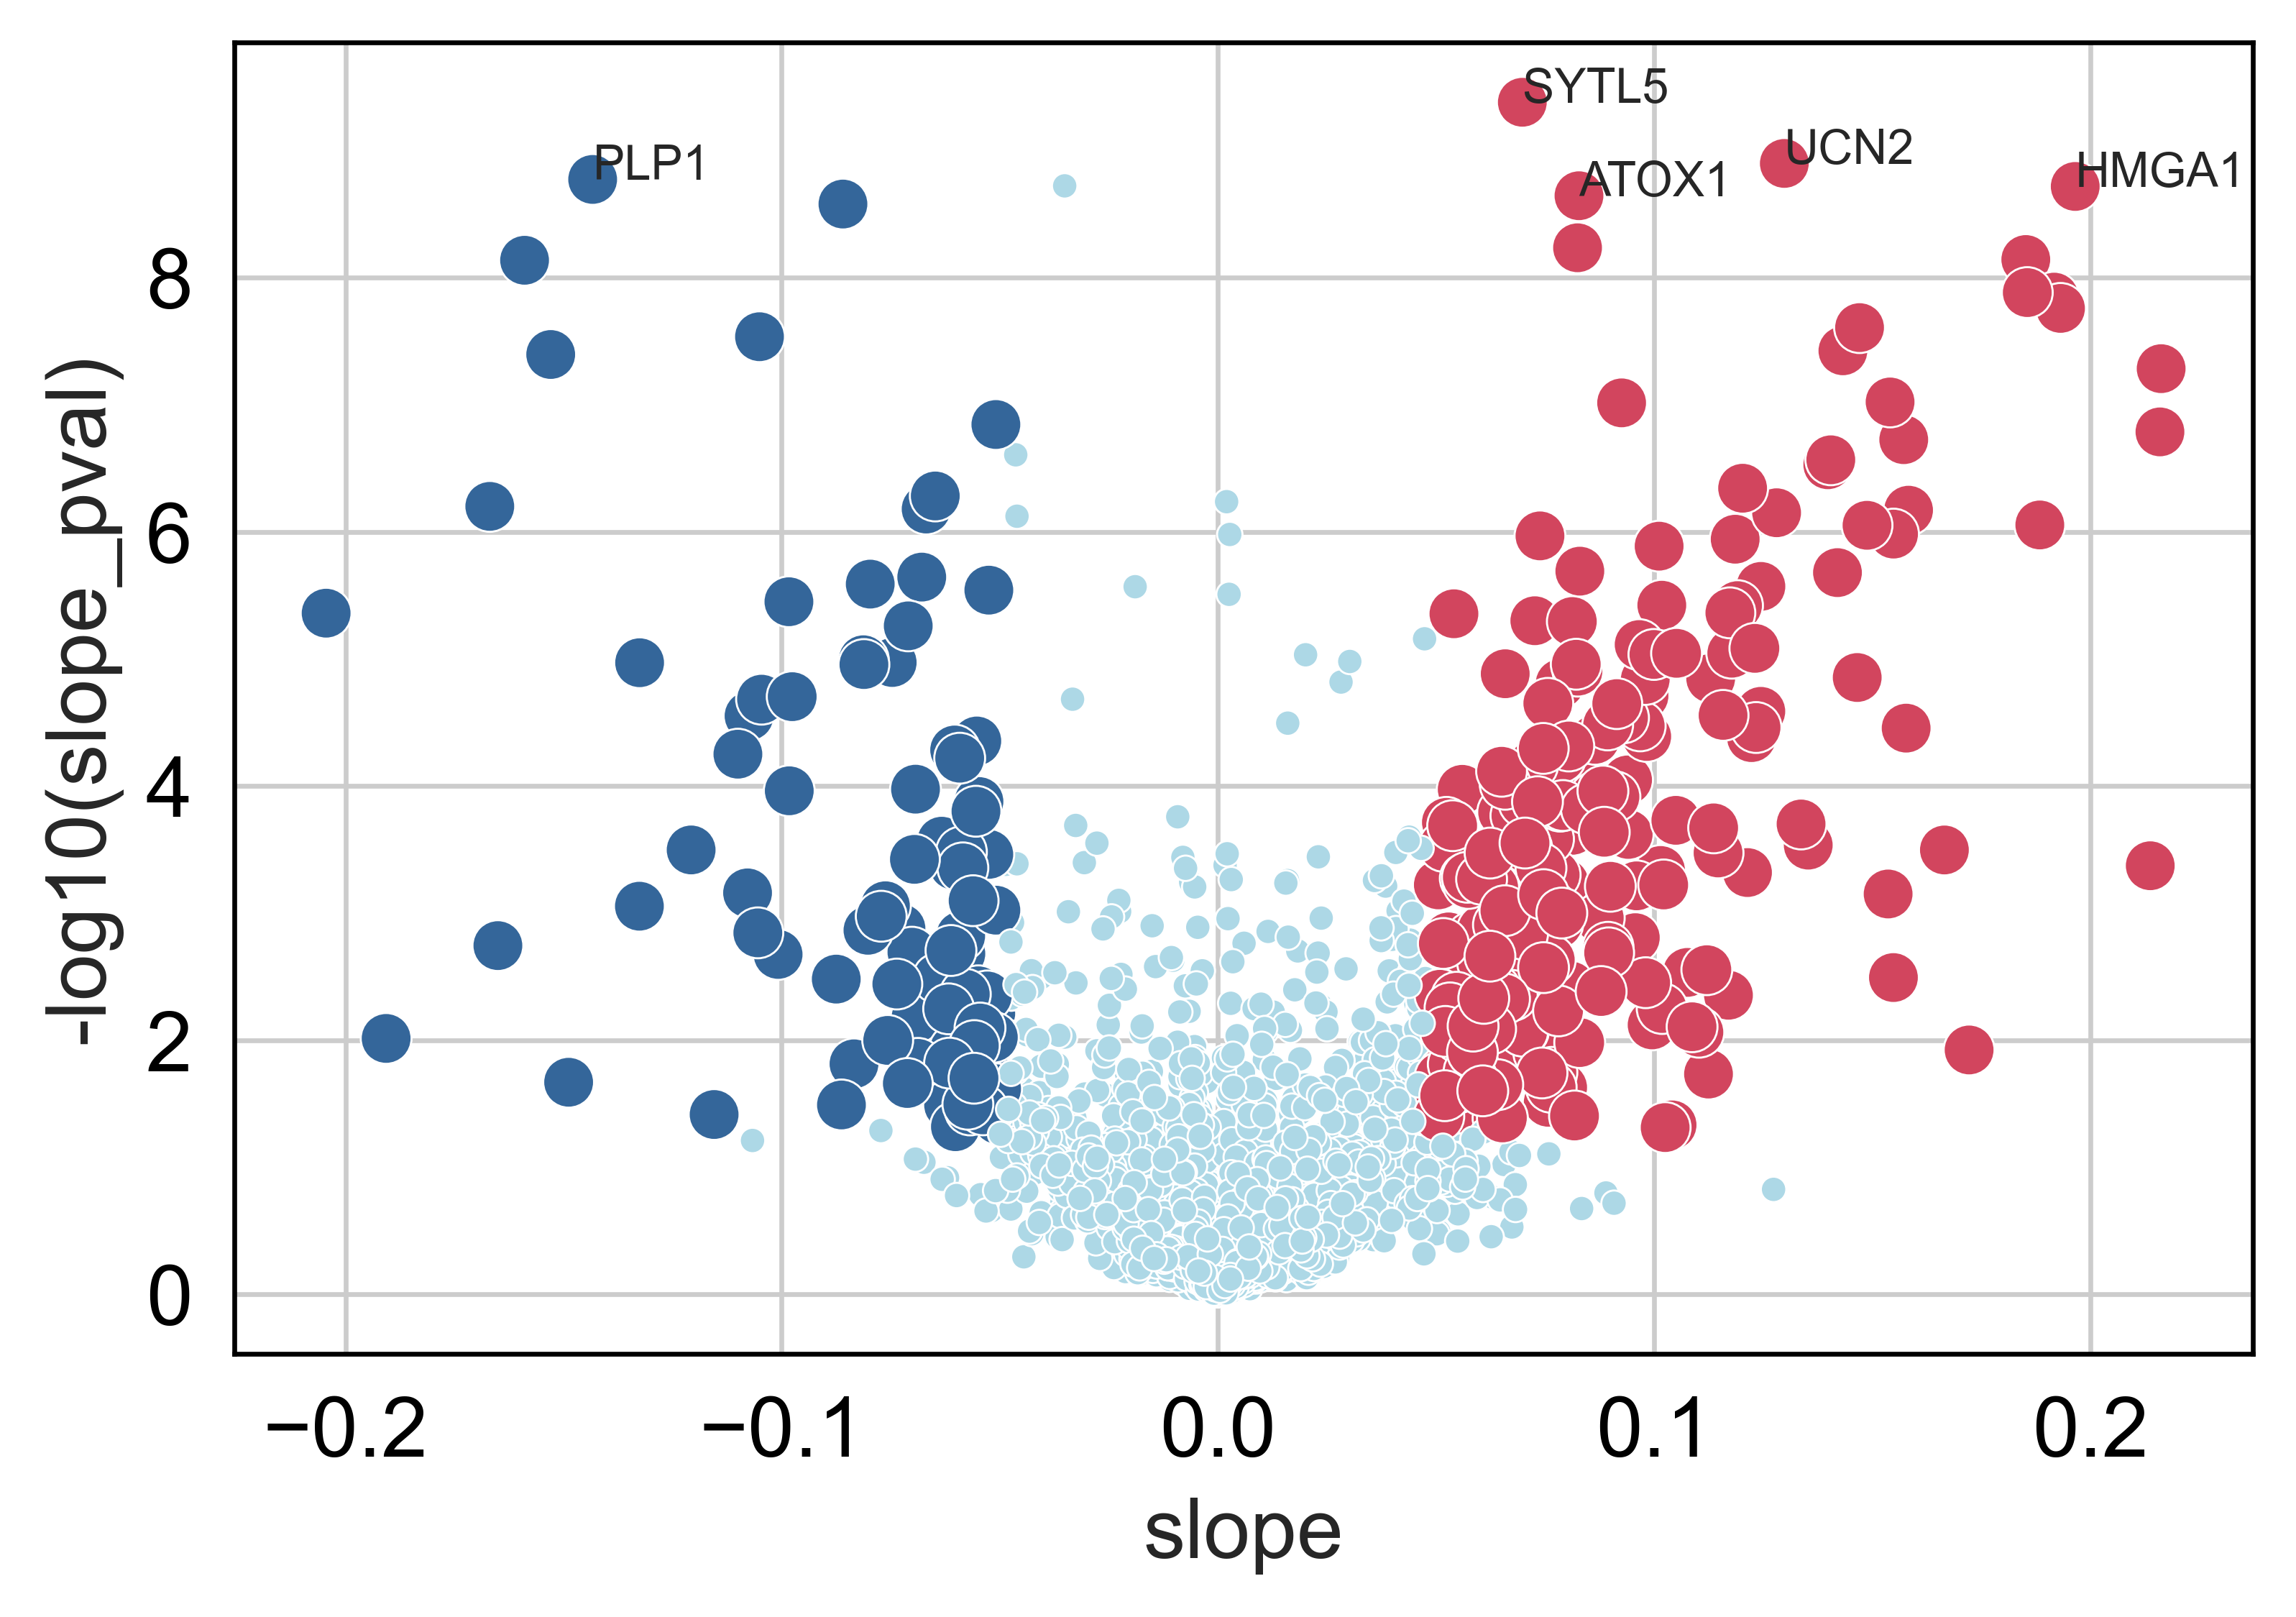

In [29]:
volcano_plot(lr_params_dabrafenib, "Dabrafenib", "slope", pval_threshold=0.05, value_threshold=0.05)

In [30]:
gsea(lr_params_dabrafenib, "Dabrafenib", "intercept", pval_threshold=0.01, domain="rea")

Number of genes UP: 149, DOWN: 289
['BP' 'CC' 'MF' 'cor' 'keg' 'mir' 'rea']
95 300


Number of genes UP: 414, DOWN: 246
['BP' 'CC' 'MF' 'cor' 'keg' 'mir' 'rea' 'tf']
241 87


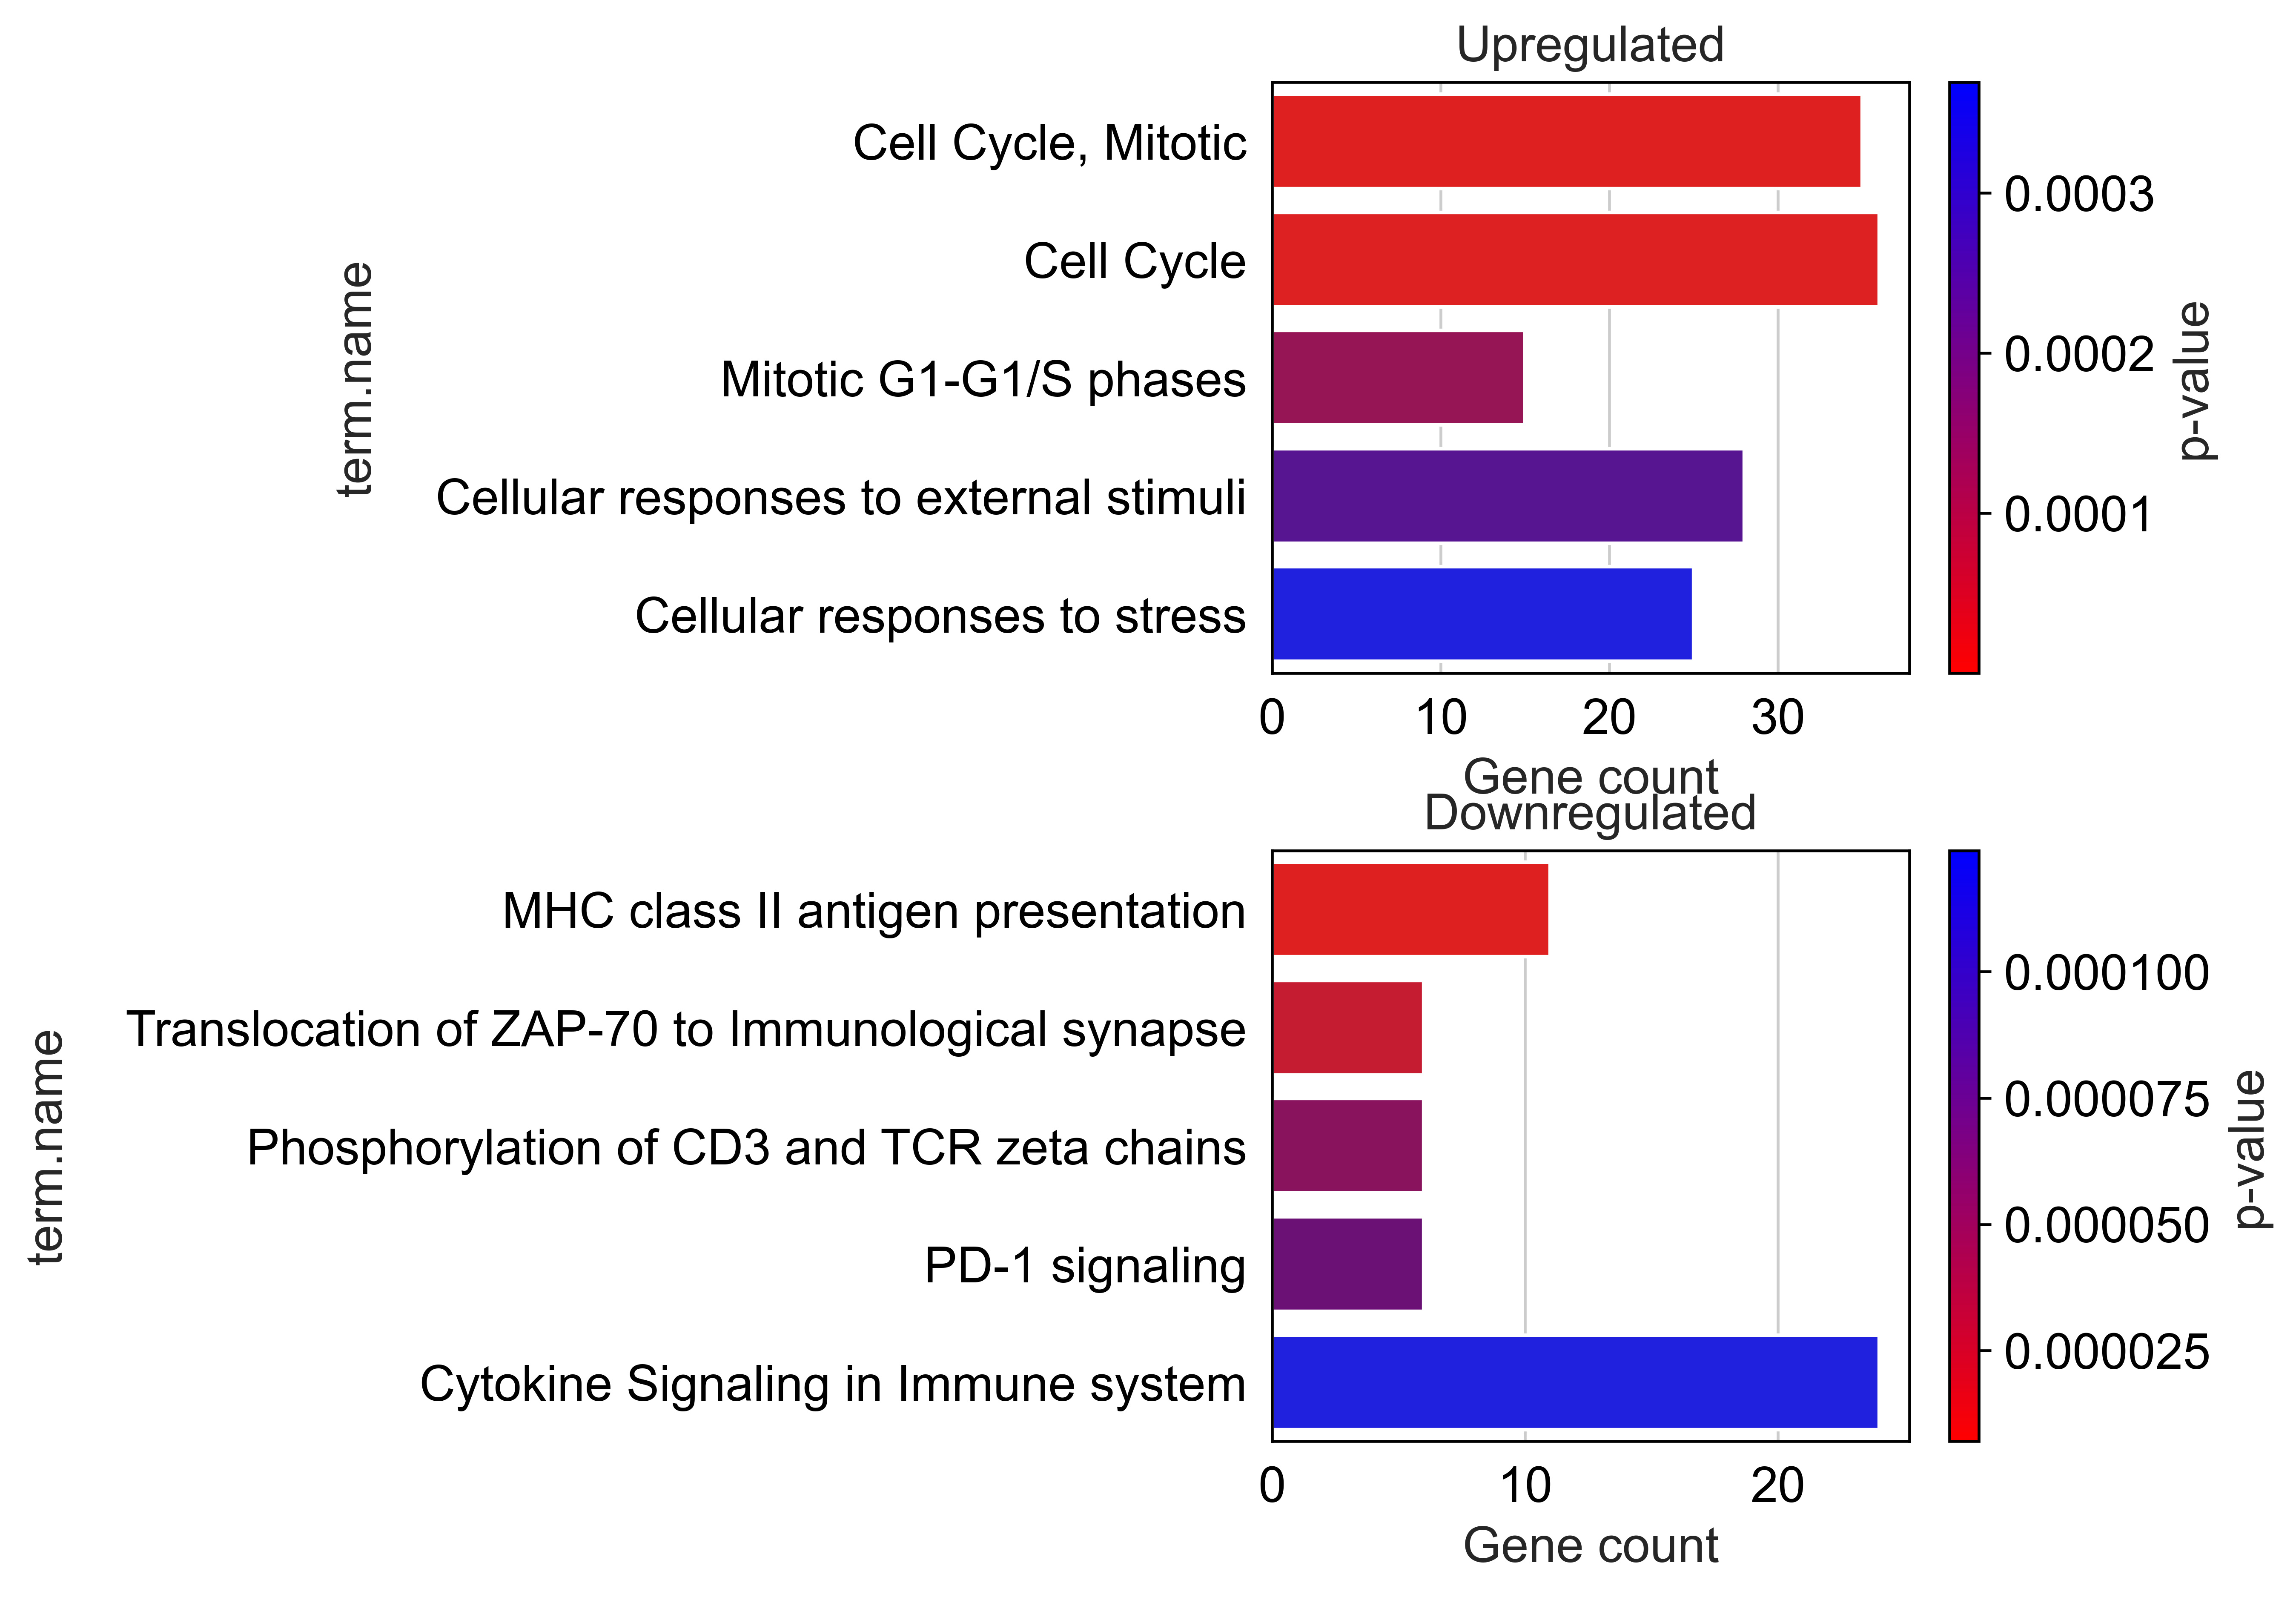

In [32]:
gsea(lr_params_dabrafenib, "Dabrafenib", "slope", pval_threshold=0.05, domain="rea")

# Navitoclax HVGs (Main Figure)

In [15]:
#rename Navitoclax to Navitoclax-HVGs
adata.obs["perturbation"] = adata.obs["perturbation"].replace("Navitoclax", "Navitoclax-HVGs")

In [17]:
logfc_df_navitoclax = comp_edger(adata, "Navitoclax-HVGs")
logfc_df_navitoclax

perturbation
control            29143
Navitoclax-HVGs     9623
Name: count, dtype: int64


100%|██████████| 139/139 [05:06<00:00,  2.20s/it]


RP11-206L10.2    SAMD11      HES4     ISG15    RNF223  \
SIDM00931  -3.620239e-02 -0.180580 -0.252717 -1.131405  0.000000   
SIDM00505   0.000000e+00 -0.473998 -0.394933 -2.051914  0.000000   
SIDM00839   2.315538e-02  0.004651 -0.061278 -0.499301 -0.076206   
SIDM00480  -9.984955e-03 -0.117479 -0.585026 -1.357584 -0.054379   
SIDM00919   8.871740e-02  0.137735 -0.222993  0.404485  0.092152   
...                  ...       ...       ...       ...       ...   
SIDM00840  -8.602419e-02  1.176162 -0.557836 -0.344123 -0.210304   
SIDM00664   0.000000e+00  0.977514  0.305298 -1.648759 -0.211515   
SIDM00194   0.000000e+00 -0.056612  0.169578 -0.452136  0.617090   
SIDM00837   2.562741e-15 -0.129564  0.352832 -0.135127 -0.304826   
SIDM00143   0.000000e+00 -0.114865 -0.120364 -0.354690  0.335989   

           RP11-465B22.5  RP11-465B22.8      MIB2  C1orf222          HES5  \
SIDM00931   0.000000e+00      -0.097992  0.124939 -0.016983  0.000000e+00   
SIDM00505   0.000000e+00       0.000000 -0.190404  0.000000  0.000000e+00   
SIDM00839   0.000000e+00       0.536063 -0.151439  0.000000  4.254432e-02   
SIDM00480   0.000000e+00      -0.365161  0.092708 -0.015732  0.000000e+00   
SIDM00919   0.000000e+00       0.123681  0.156912  0.096778 -3.045349e-02   
...                  ...            ...       ...       ...           ...   
SIDM00840   0.000000e+00       0.327856  0.919515 -0.226480  0.000000e+00   
SIDM00664   0.000000e+00       0.066736 -0.462476  0.000000  0.000000e+00   
SIDM00194   0.000000e+00      -0.236603  0.009689 -0.226132  0.000000e+00   
SIDM00837   2.562741e-15      -0.566997  0.343246 -0.152870  2.562741e-15   
SIDM00143   0.000000e+00       0.362632 -0.147412  0.000000  0.000000e+00   

           ...    MT-CO2   MT-ATP8   MT-ATP6    MT-CO3    MT-ND3   MT-ND4L  \
SIDM00931  ...  0.004010 -0.343828  0.199108  0.063640 -0.051709 -0.549442   
SIDM00505  ...  0.070074 -0.621681  0.094932  0.090558 -0.066249 -0.466809   
SIDM00839  ... -0.231710 -0.998437 -0.375359 -0.281112 -0.826138 -0.409213   
SIDM00480  ... -0.001763 -0.316249  0.085693  0.062813 -0.089345 -0.314720   
SIDM00919  ... -0.091558 -0.837437 -0.188109 -0.054073 -0.491240  0.094763   
...        ...       ...       ...       ...       ...       ...       ...   
SIDM00840  ... -0.262131 -0.377680  0.143283  0.054046  0.408952 -0.186724   
SIDM00664  ...  0.218385  0.325502  0.397350  0.310918  0.454087 -0.310858   
SIDM00194  ...  0.112676 -0.056787  0.164418  0.202041 -0.075139 -0.318451   
SIDM00837  ... -0.270331 -0.623325 -0.524825 -0.141888 -0.942446 -0.776199   
SIDM00143  ...  0.017382 -0.603380  0.047406  0.092618 -0.087533 -0.310642   

             MT-ND4    MT-ND5    MT-ND6    MT-CYB  
SIDM00931  0.016858 -0.117856 -0.101553  0.003787  
SIDM00505  0.064981 -0.167484 -0.314769  0.064172  
SIDM00839 -0.192494 -0.223210 -0.308500 -0.353456  
SIDM00480  0.007717  0.004044 -0.343358  0.016304  
SIDM00919  0.064200 -0.068243 -0.263682 -0.092369  
...             ...       ...       ...       ...  
SIDM00840 -0.267907 -0.025686  0.284947 -0.198730  
SIDM00664  0.252726  0.173362  0.411103  0.194144  
SIDM00194  0.161382  0.191429 -0.169216  0.147494  
SIDM00837 -0.174508 -0.614021  0.141067 -0.268605  
SIDM00143  0.055451  0.070346 -0.534134  0.150273  

[81 rows x 4000 columns]

In [18]:
lr_params_navitoclax = comp_linear_regression(adata, "Navitoclax-HVGs", 2, logfc_df_navitoclax)
lr_params_navitoclax.to_csv("output/linear_regression_results_navitoclax-HVGs.csv")

perturbation
control            29143
Navitoclax-HVGs     9623
Name: count, dtype: int64


100%|██████████| 4000/4000 [00:02<00:00, 1381.58it/s]


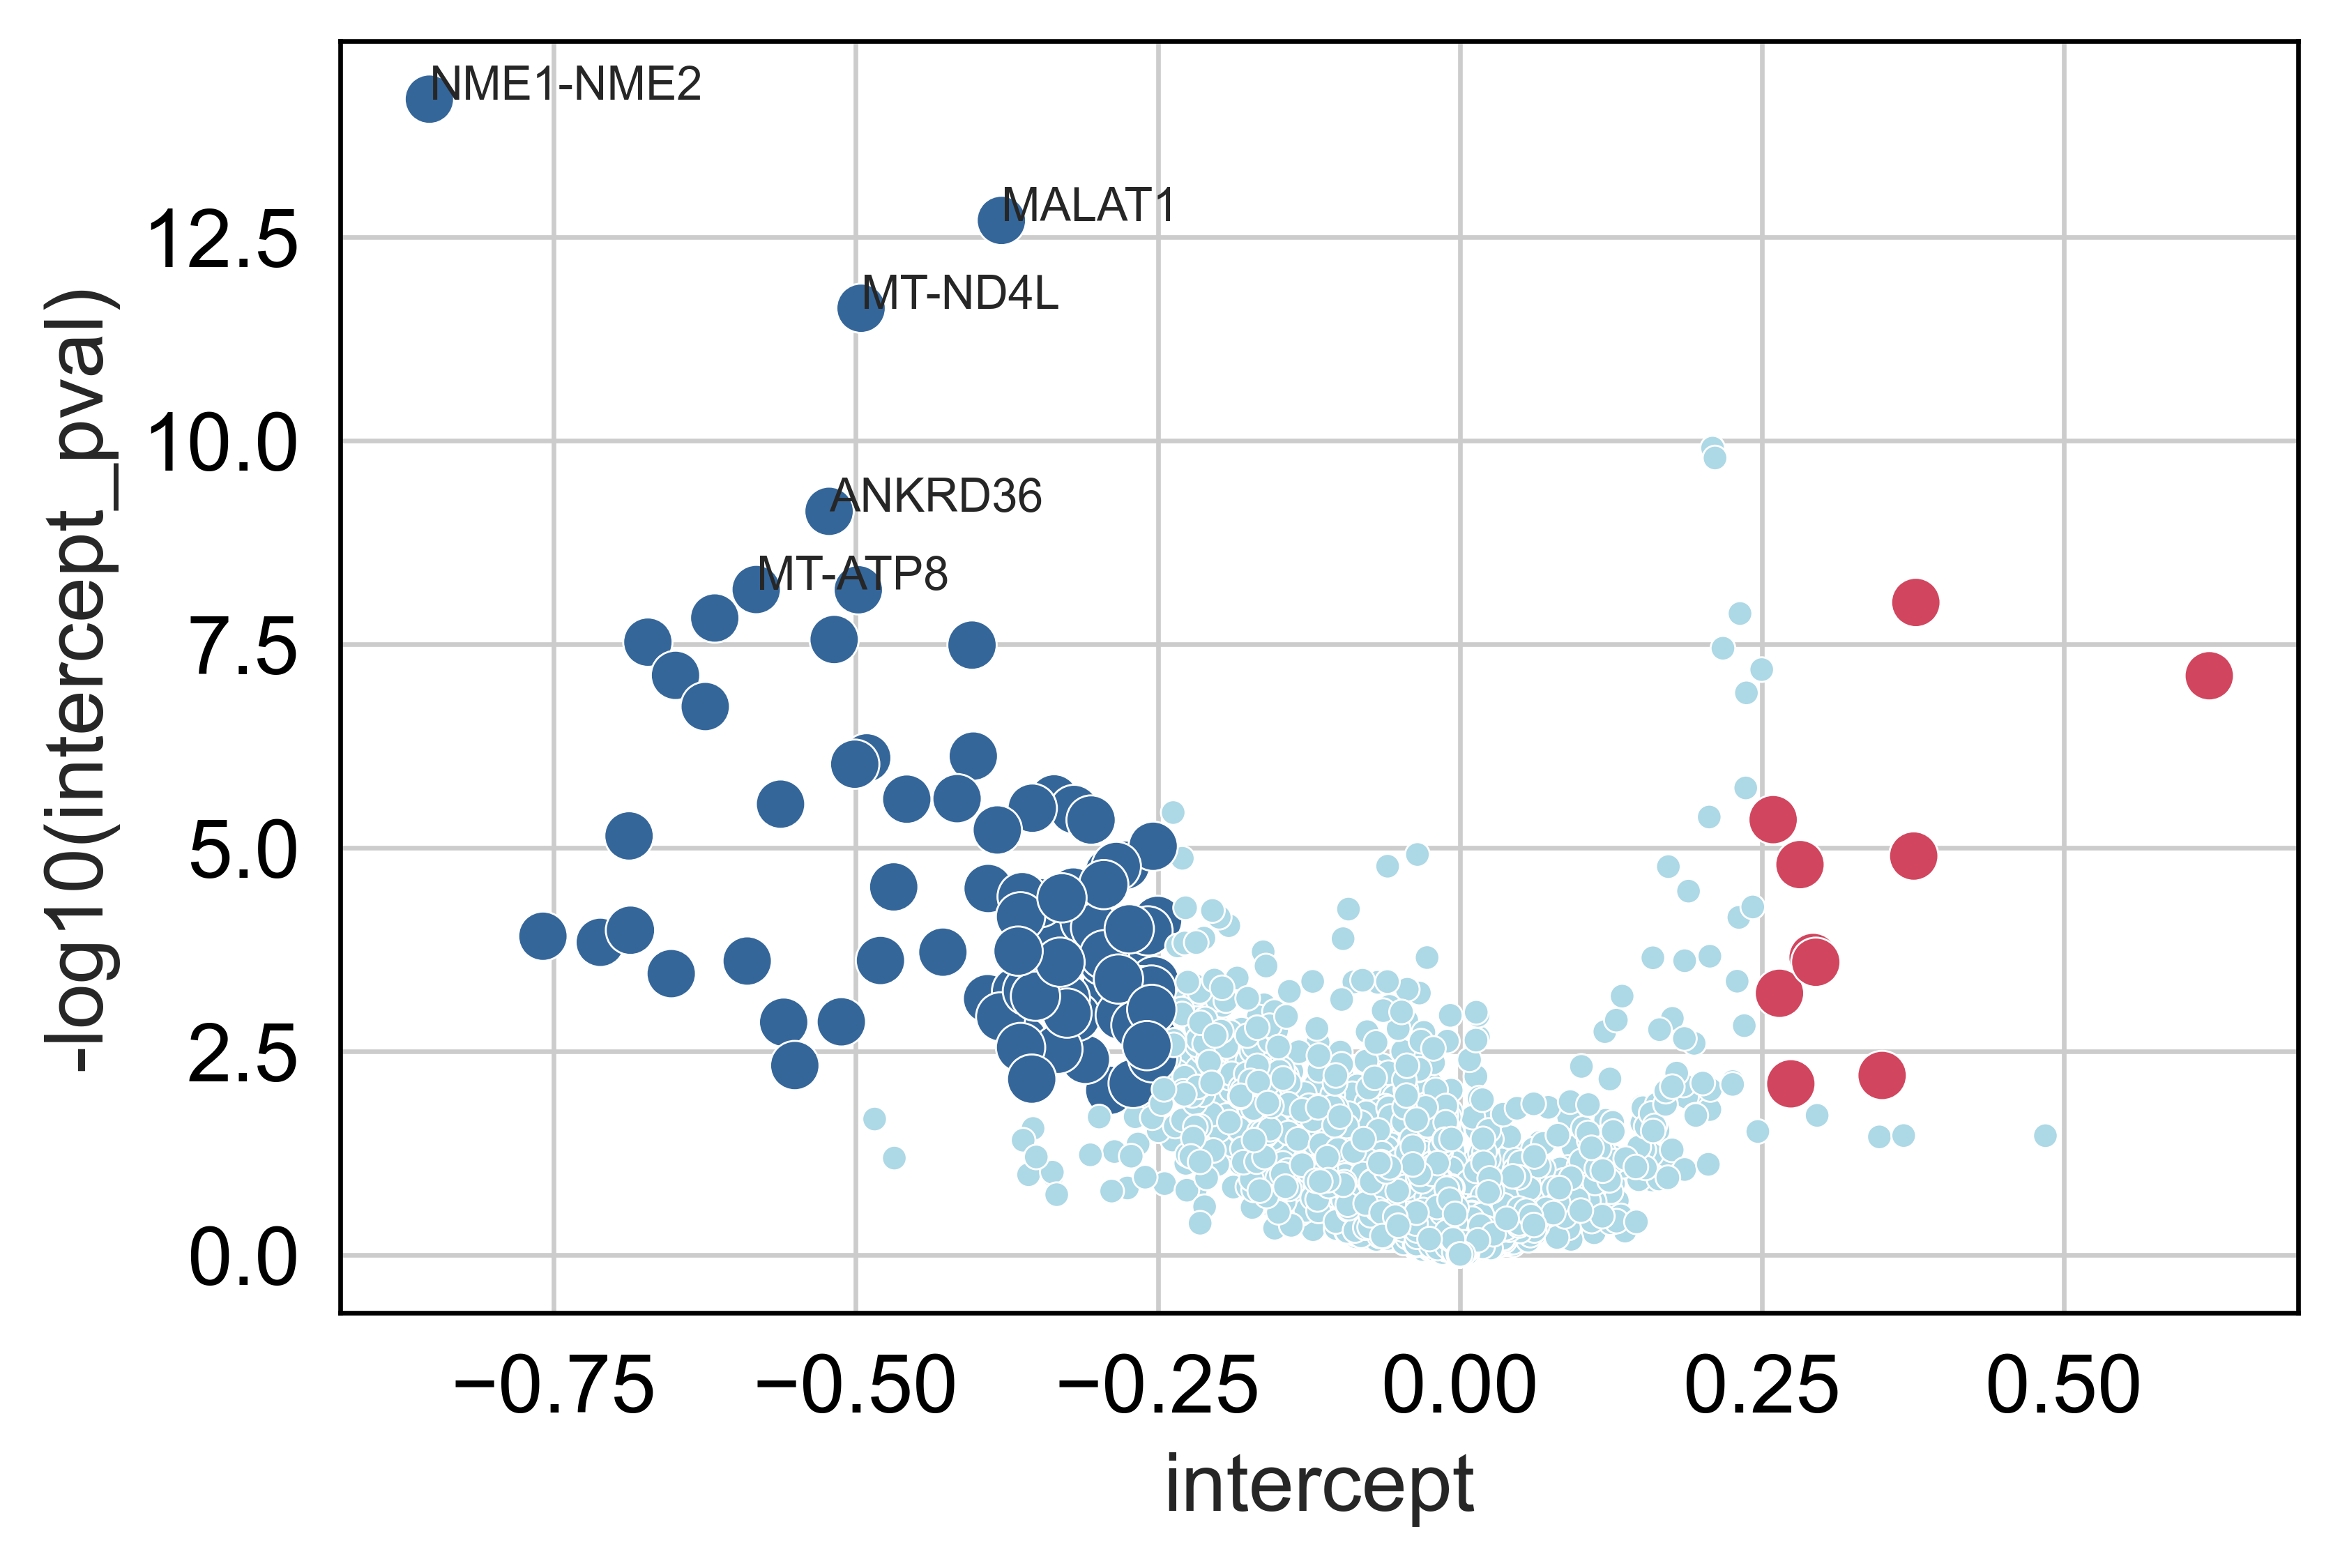

In [19]:
volcano_plot(lr_params_navitoclax, "Navitoclax-HVGs", "intercept", pval_threshold=0.01, value_threshold=0.25)

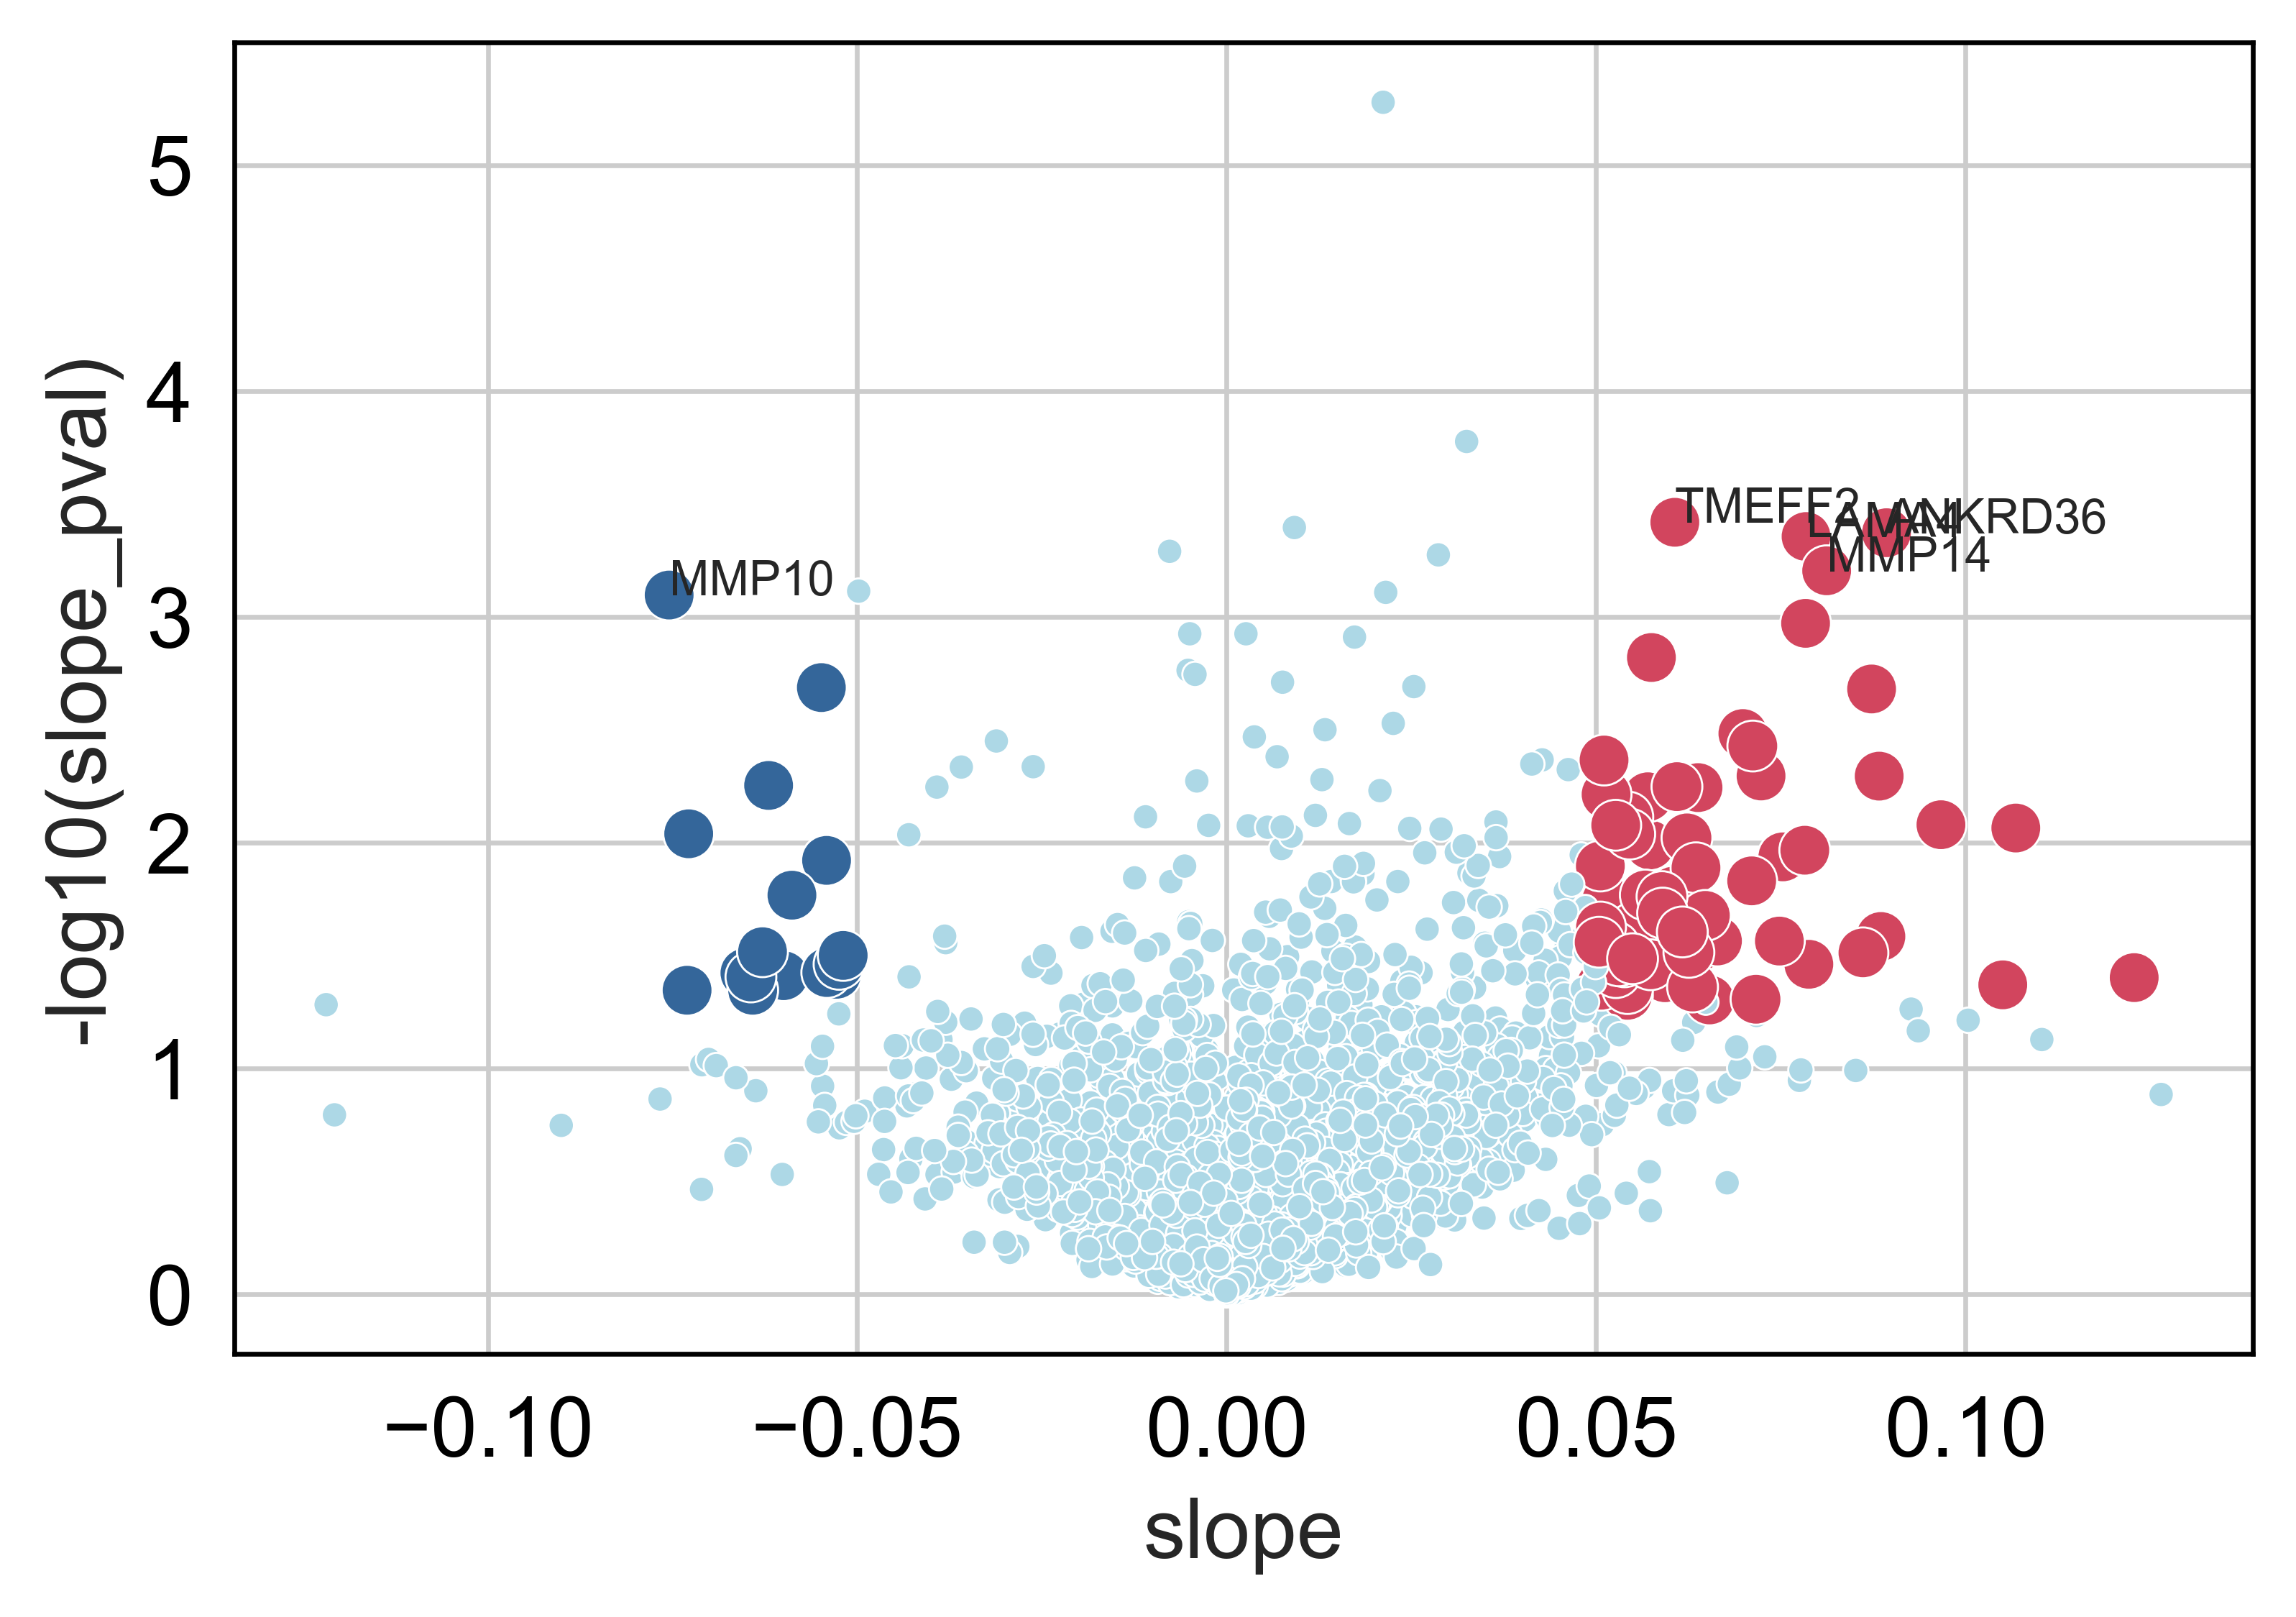

In [20]:
volcano_plot(lr_params_navitoclax, "Navitoclax-HVGs", "slope", pval_threshold=0.05, value_threshold=0.05)

In [23]:
results = gsea(lr_params_navitoclax,
               "Navitoclax-HVGs",
               "intercept",
               pval_threshold=0.01,
               value_threshold_up=0.25,
               value_threshold_down=-0.5,
               domain="rea",
               )

Number of genes UP: 50, DOWN: 283
['BP' 'CC' 'MF' 'cor' 'keg' 'mir' 'rea' 'tf']
45 168


Number of genes UP: 197, DOWN: 58
['BP' 'CC' 'MF' 'cor' 'hp']
27 1


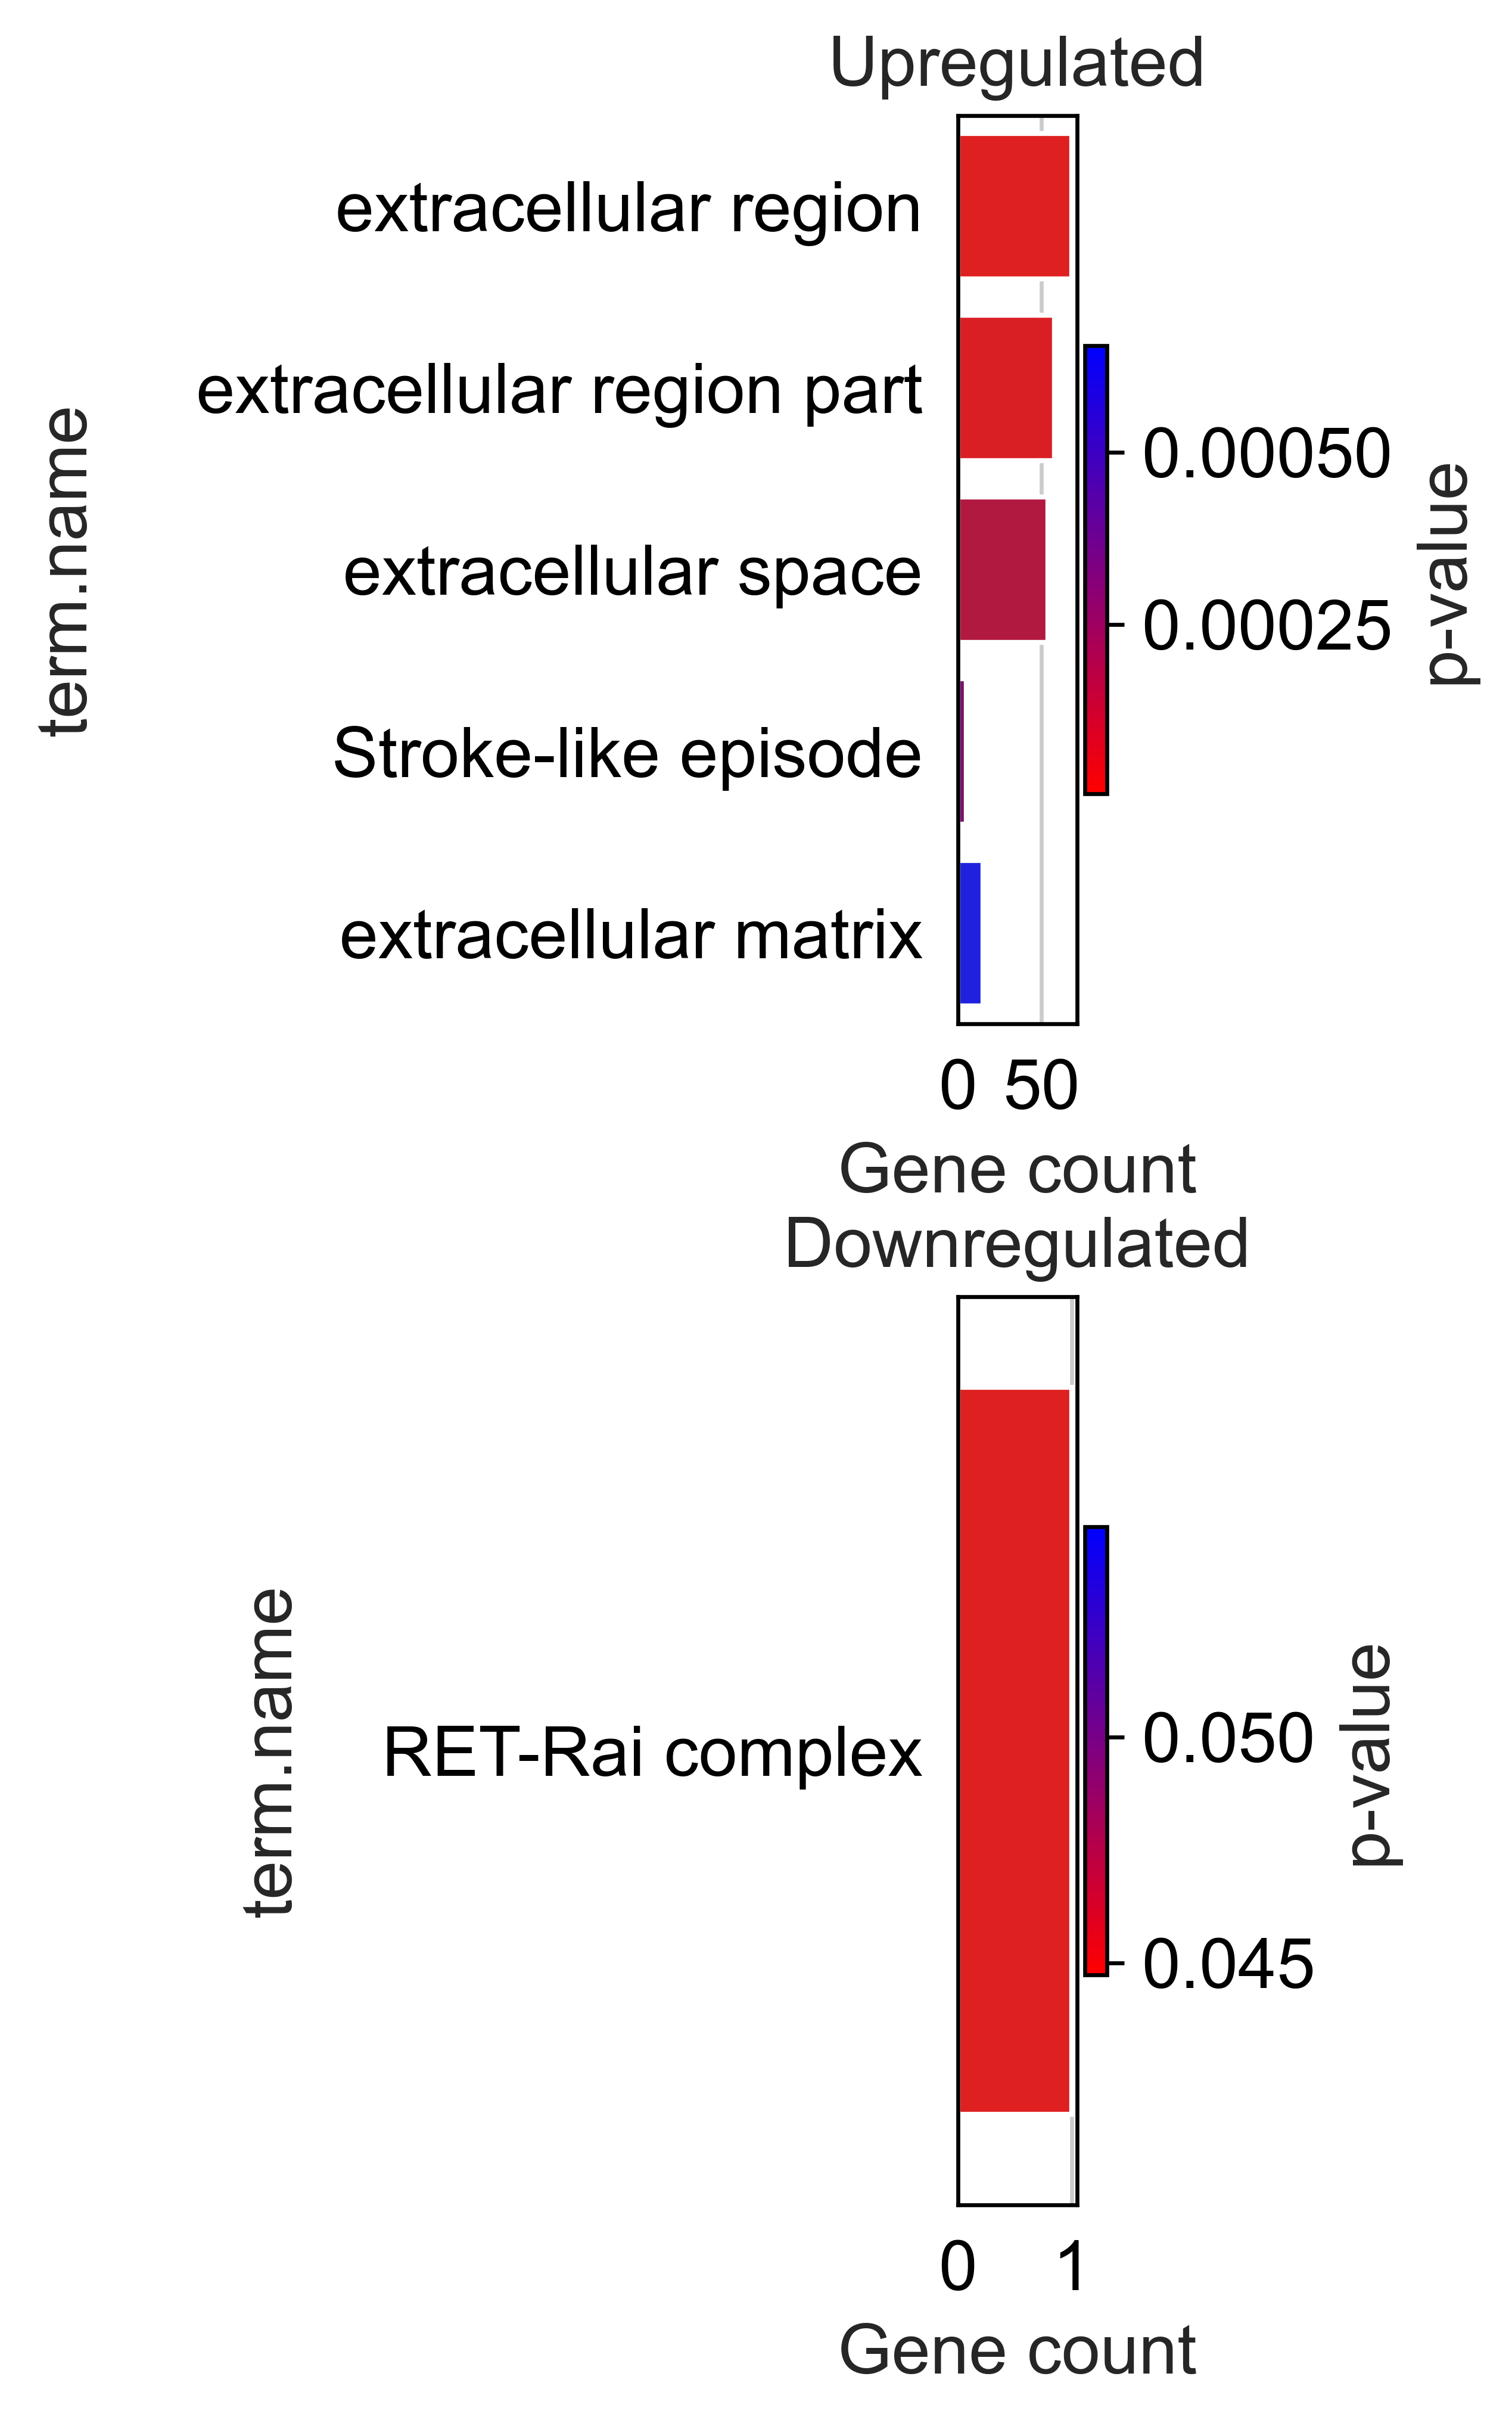

In [25]:
results = gsea(lr_params_navitoclax,
               "Navitoclax-HVGs",
               "slope",
               pval_threshold=0.05,
               value_threshold_up=0.07,
               value_threshold_down=-0.001,
               #domain="BP",
               )

# Navitoclax (Main Figure)

In [15]:
#logfc_df_navitoclax = comp_edger(adata, "Navitoclax")
logfc_df_navitoclax = pd.read_pickle("data/logfc_df_Navitoclax.pkl")
logfc_df_navitoclax

MIR1302-10  FAM138A  OR4F5  RP11-34P13.7  RP11-34P13.8  AL627309.1  \
SIDM00931         0.0      0.0    0.0      0.006156           0.0    0.013088   
SIDM00505         0.0      0.0    0.0      0.043435           0.0    0.000000   
SIDM00839         0.0      0.0    0.0      0.106247           0.0    0.146410   
SIDM00480         0.0      0.0    0.0     -0.016062           0.0    0.021401   
SIDM00919         0.0      0.0    0.0     -0.084499           0.0   -0.138503   
...               ...      ...    ...           ...           ...         ...   
SIDM00840         0.0      0.0    0.0     -0.093992           0.0    0.496786   
SIDM00664         0.0      0.0    0.0      0.000000           0.0    0.000000   
SIDM00194         0.0      0.0    0.0     -0.190831           0.0   -0.186846   
SIDM00837         0.0      0.0    0.0      0.000000           0.0   -0.372215   
SIDM00143         0.0      0.0    0.0      0.000000           0.0   -0.588531   

           RP11-34P13.14  RP11-34P13.9  AP006222.2  RP4-669L17.10  ...  \
SIDM00931            0.0      0.000000   -0.155862      -0.079950  ...   
SIDM00505            0.0      0.000000   -0.255387       0.024323  ...   
SIDM00839            0.0     -0.024771   -0.036091       0.033871  ...   
SIDM00480            0.0      0.000000   -0.350204       0.027601  ...   
SIDM00919            0.0      0.000000    0.299062      -0.085044  ...   
...                  ...           ...         ...            ...  ...   
SIDM00840            0.0      0.000000   -0.604502       0.089911  ...   
SIDM00664            0.0      0.000000   -0.016846       0.000000  ...   
SIDM00194            0.0      0.000000    0.263372       0.000000  ...   
SIDM00837            0.0      0.000000    0.584128      -0.080308  ...   
SIDM00143            0.0      0.000000   -0.441015       0.146993  ...   

           KIR3DL2-1  AL590523.1  CT476828.1   PNRC2-1  SRSF10-1  AC145205.1  \
SIDM00931        0.0         0.0         0.0  0.043000  0.046903         0.0   
SIDM00505        0.0         0.0         0.0 -0.298909 -0.183506         0.0   
SIDM00839        0.0         0.0         0.0 -0.021819 -0.166761         0.0   
SIDM00480        0.0         0.0         0.0 -0.057079  0.277395         0.0   
SIDM00919        0.0         0.0         0.0 -0.058186  0.045151         0.0   
...              ...         ...         ...       ...       ...         ...   
SIDM00840        0.0         0.0         0.0 -0.214297  0.170962         0.0   
SIDM00664        0.0         0.0         0.0 -0.103514 -1.112967         0.0   
SIDM00194        0.0         0.0         0.0  0.000000 -0.119202         0.0   
SIDM00837        0.0         0.0         0.0 -0.086133 -0.553723         0.0   
SIDM00143        0.0         0.0         0.0 -0.232573  0.764134         0.0   

           BAGE5  CU459201.1  AC002321.2  AC002321.1  
SIDM00931    0.0         0.0         0.0         0.0  
SIDM00505    0.0         0.0         0.0         0.0  
SIDM00839    0.0         0.0         0.0         0.0  
SIDM00480    0.0         0.0         0.0         0.0  
SIDM00919    0.0         0.0         0.0         0.0  
...          ...         ...         ...         ...  
SIDM00840    0.0         0.0         0.0         0.0  
SIDM00664    0.0         0.0         0.0         0.0  
SIDM00194    0.0         0.0         0.0         0.0  
SIDM00837    0.0         0.0         0.0         0.0  
SIDM00143    0.0         0.0         0.0         0.0  

[81 rows x 32738 columns]

In [16]:
lr_params_navitoclax = comp_linear_regression(adata, "Navitoclax", 2, logfc_df_navitoclax)
lr_params_navitoclax.to_csv("output/linear_regression_results_navitoclax.csv")

perturbation
control       29143
Navitoclax     9623
Name: count, dtype: int64


100%|██████████| 32738/32738 [00:48<00:00, 672.00it/s]


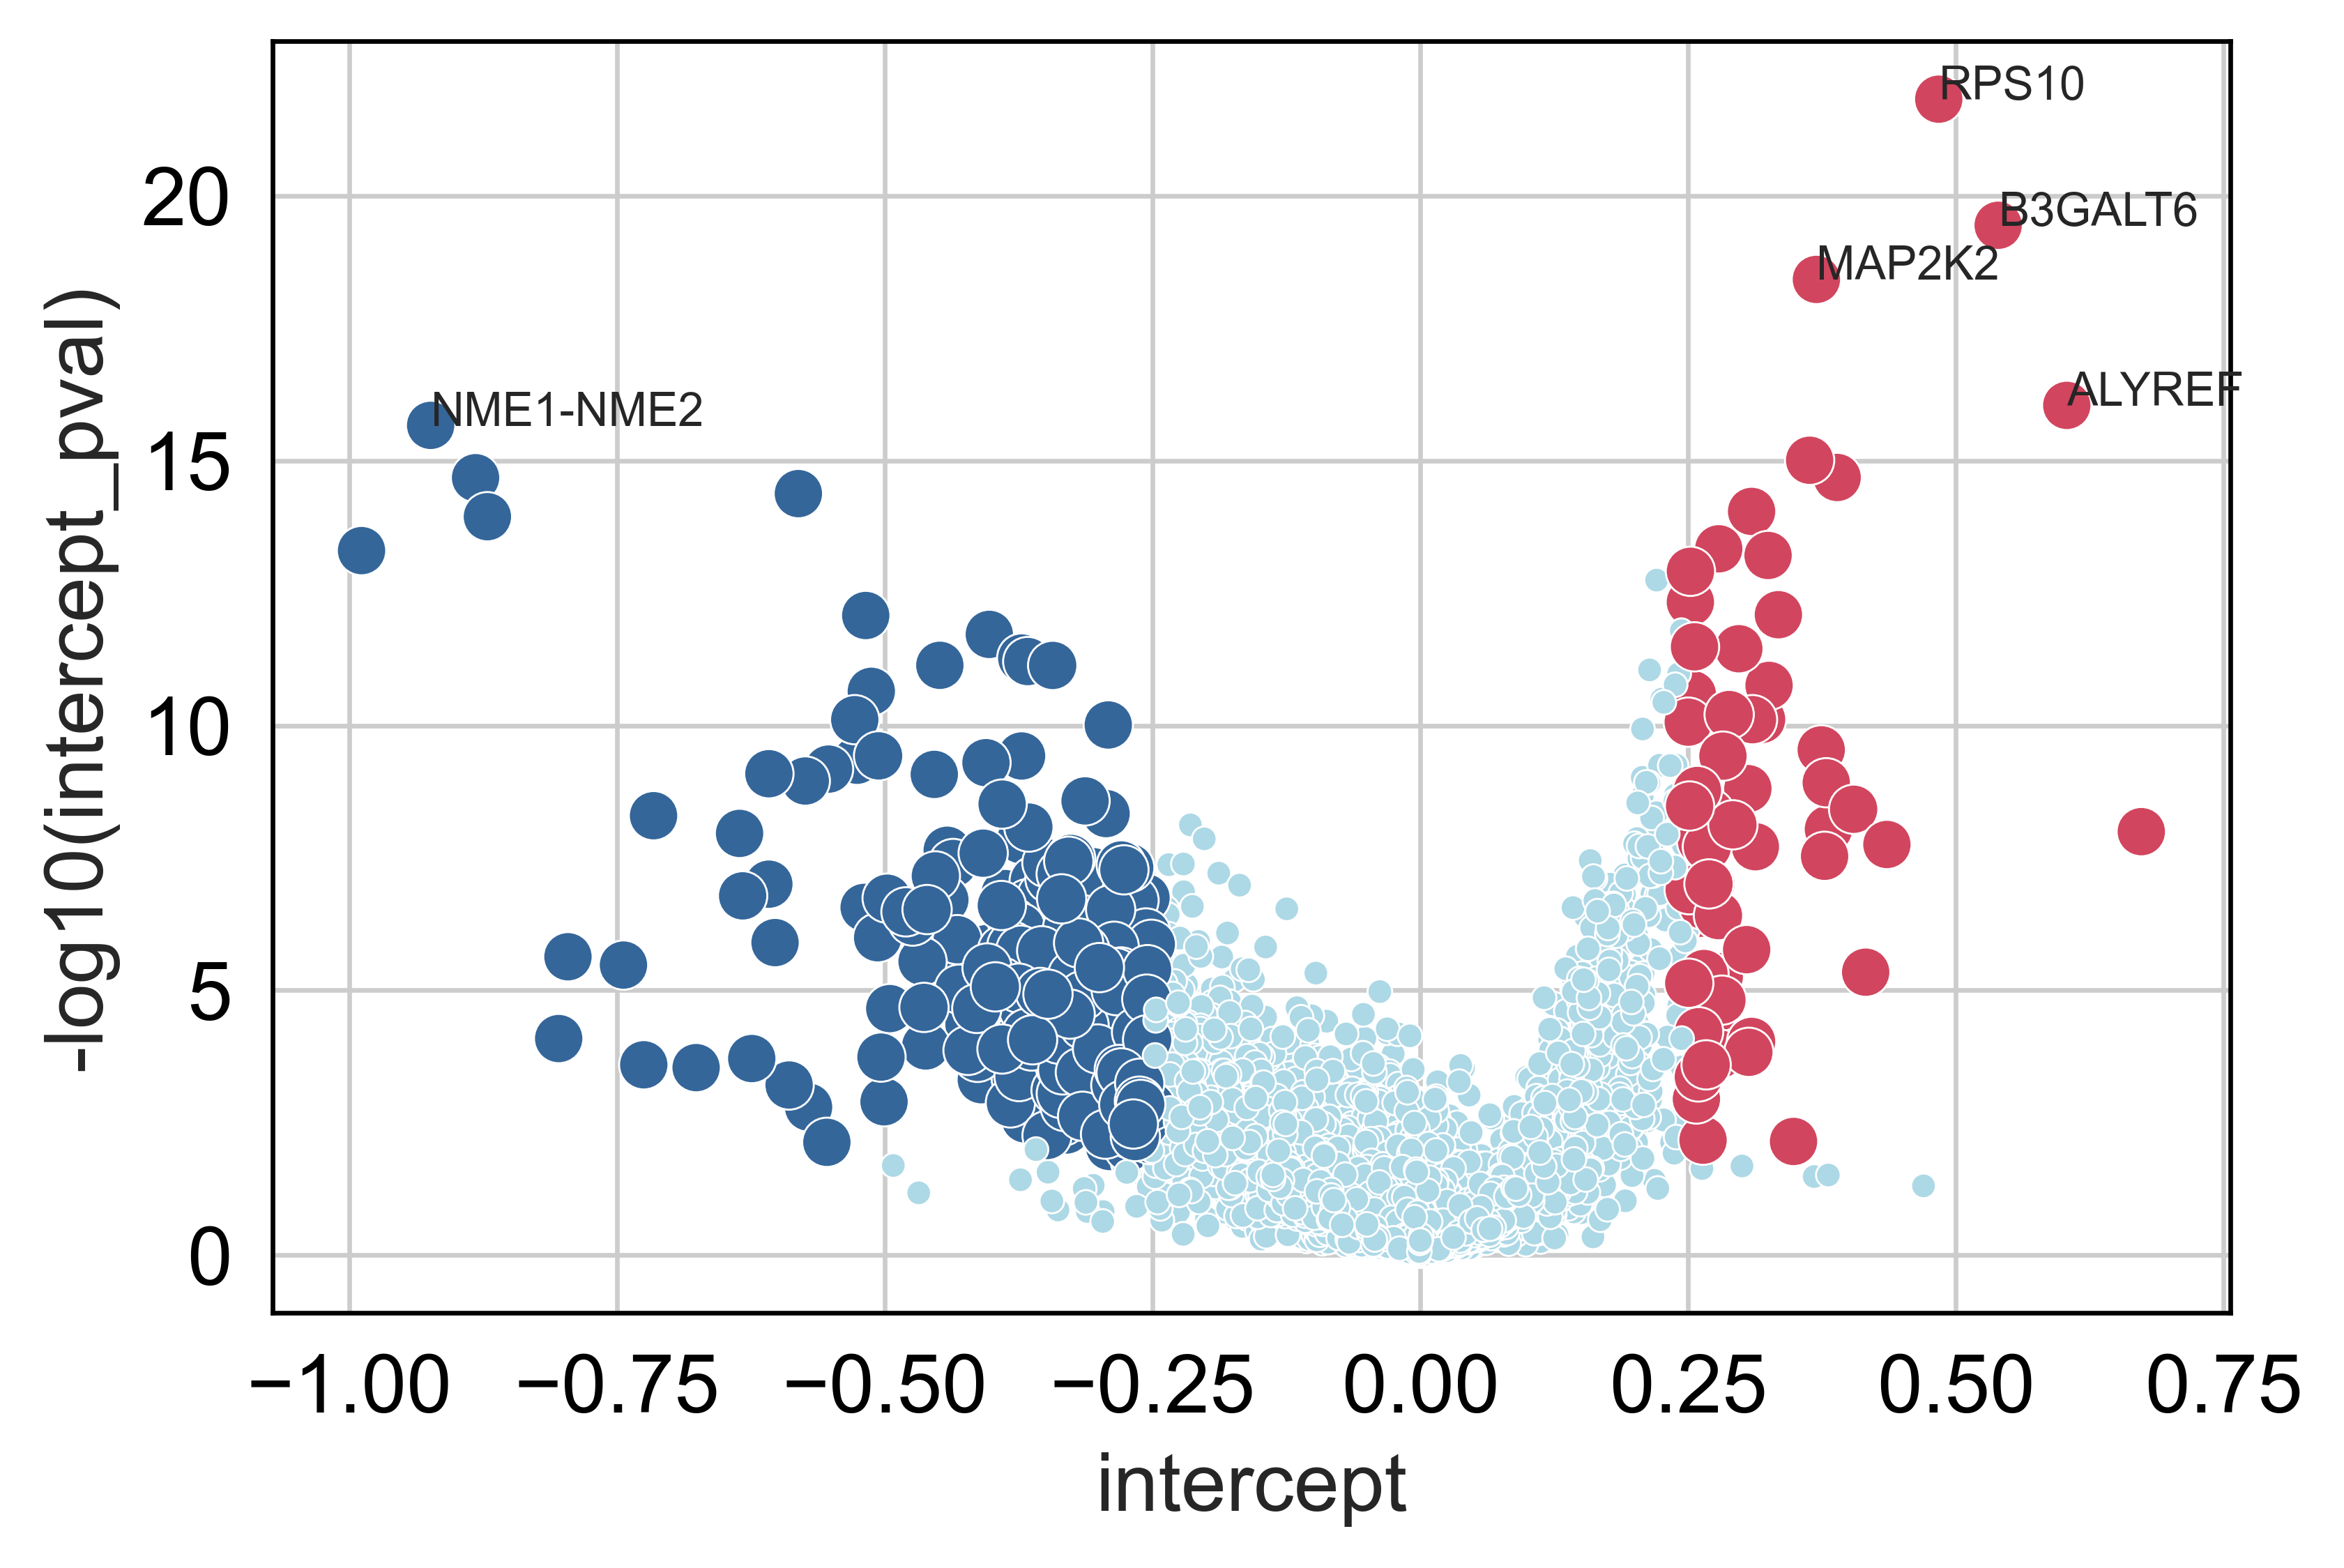

In [17]:
volcano_plot(lr_params_navitoclax, "Navitoclax", "intercept", pval_threshold=0.01, value_threshold=0.25)

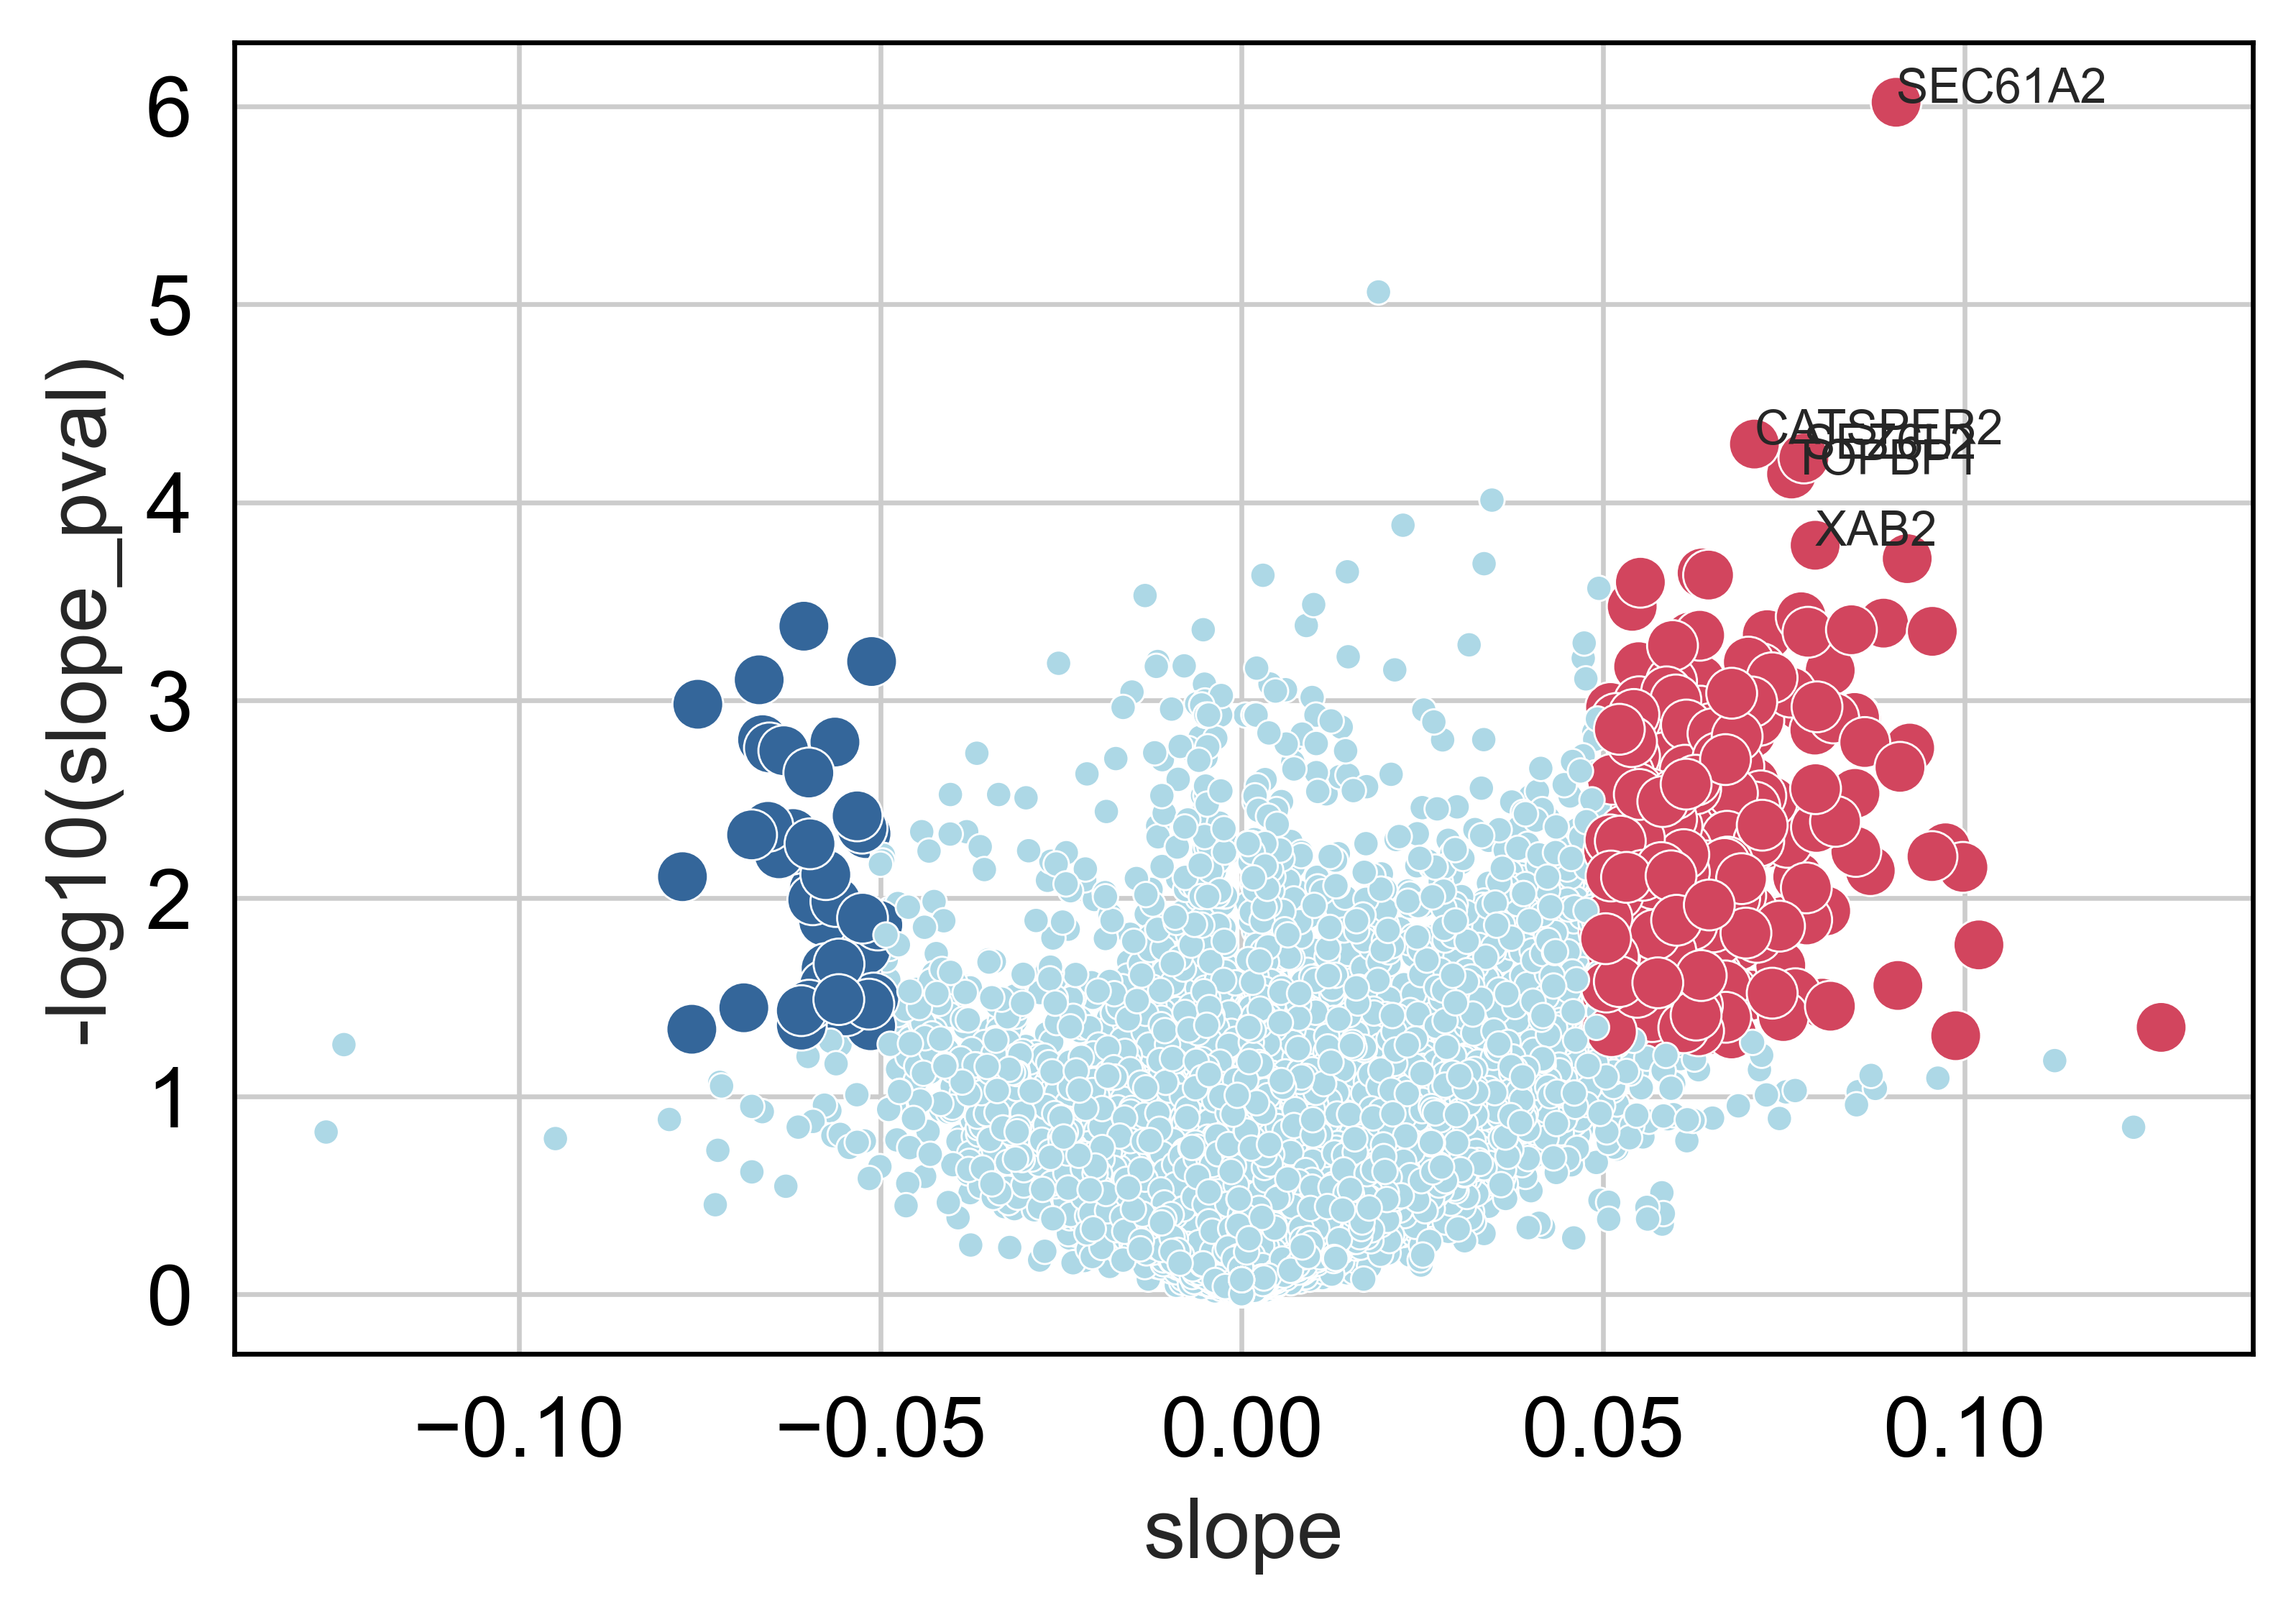

In [18]:
volcano_plot(lr_params_navitoclax, "Navitoclax", "slope", pval_threshold=0.05, value_threshold=0.05)

In [19]:
lr_params_navitoclax[(lr_params_navitoclax["slope"] < -0.1)] # & (lr_params_navitoclax["-log10(intercept_pval)"] > 15)

gene     slope  intercept  slope_pval  intercept_pval  \
IFIT1  IFIT1 -0.124237  -0.804625    0.054761        0.000081   
CCL5    CCL5 -0.126700  -0.221477    0.151284        0.402469   

       -log10(slope_pval)  -log10(intercept_pval)      color  size  
IFIT1            1.261532                4.090075  lightblue   1.0  
CCL5             0.820208                0.395268  lightblue   1.0

In [20]:
plot_example_linear_regression(adata, "Navitoclax", "SEC61A2", 2, logfc_df_navitoclax)

perturbation
control       29143
Navitoclax     9623
Name: count, dtype: int64


In [21]:
plot_example_linear_regression(adata, "Navitoclax", "RPS10", 2, logfc_df_navitoclax)

perturbation
control       29143
Navitoclax     9623
Name: count, dtype: int64


Number of genes UP: 692, DOWN: 2627
['BP' 'CC' 'MF' 'cor' 'hp' 'hpa' 'keg' 'mir' 'rea' 'tf']


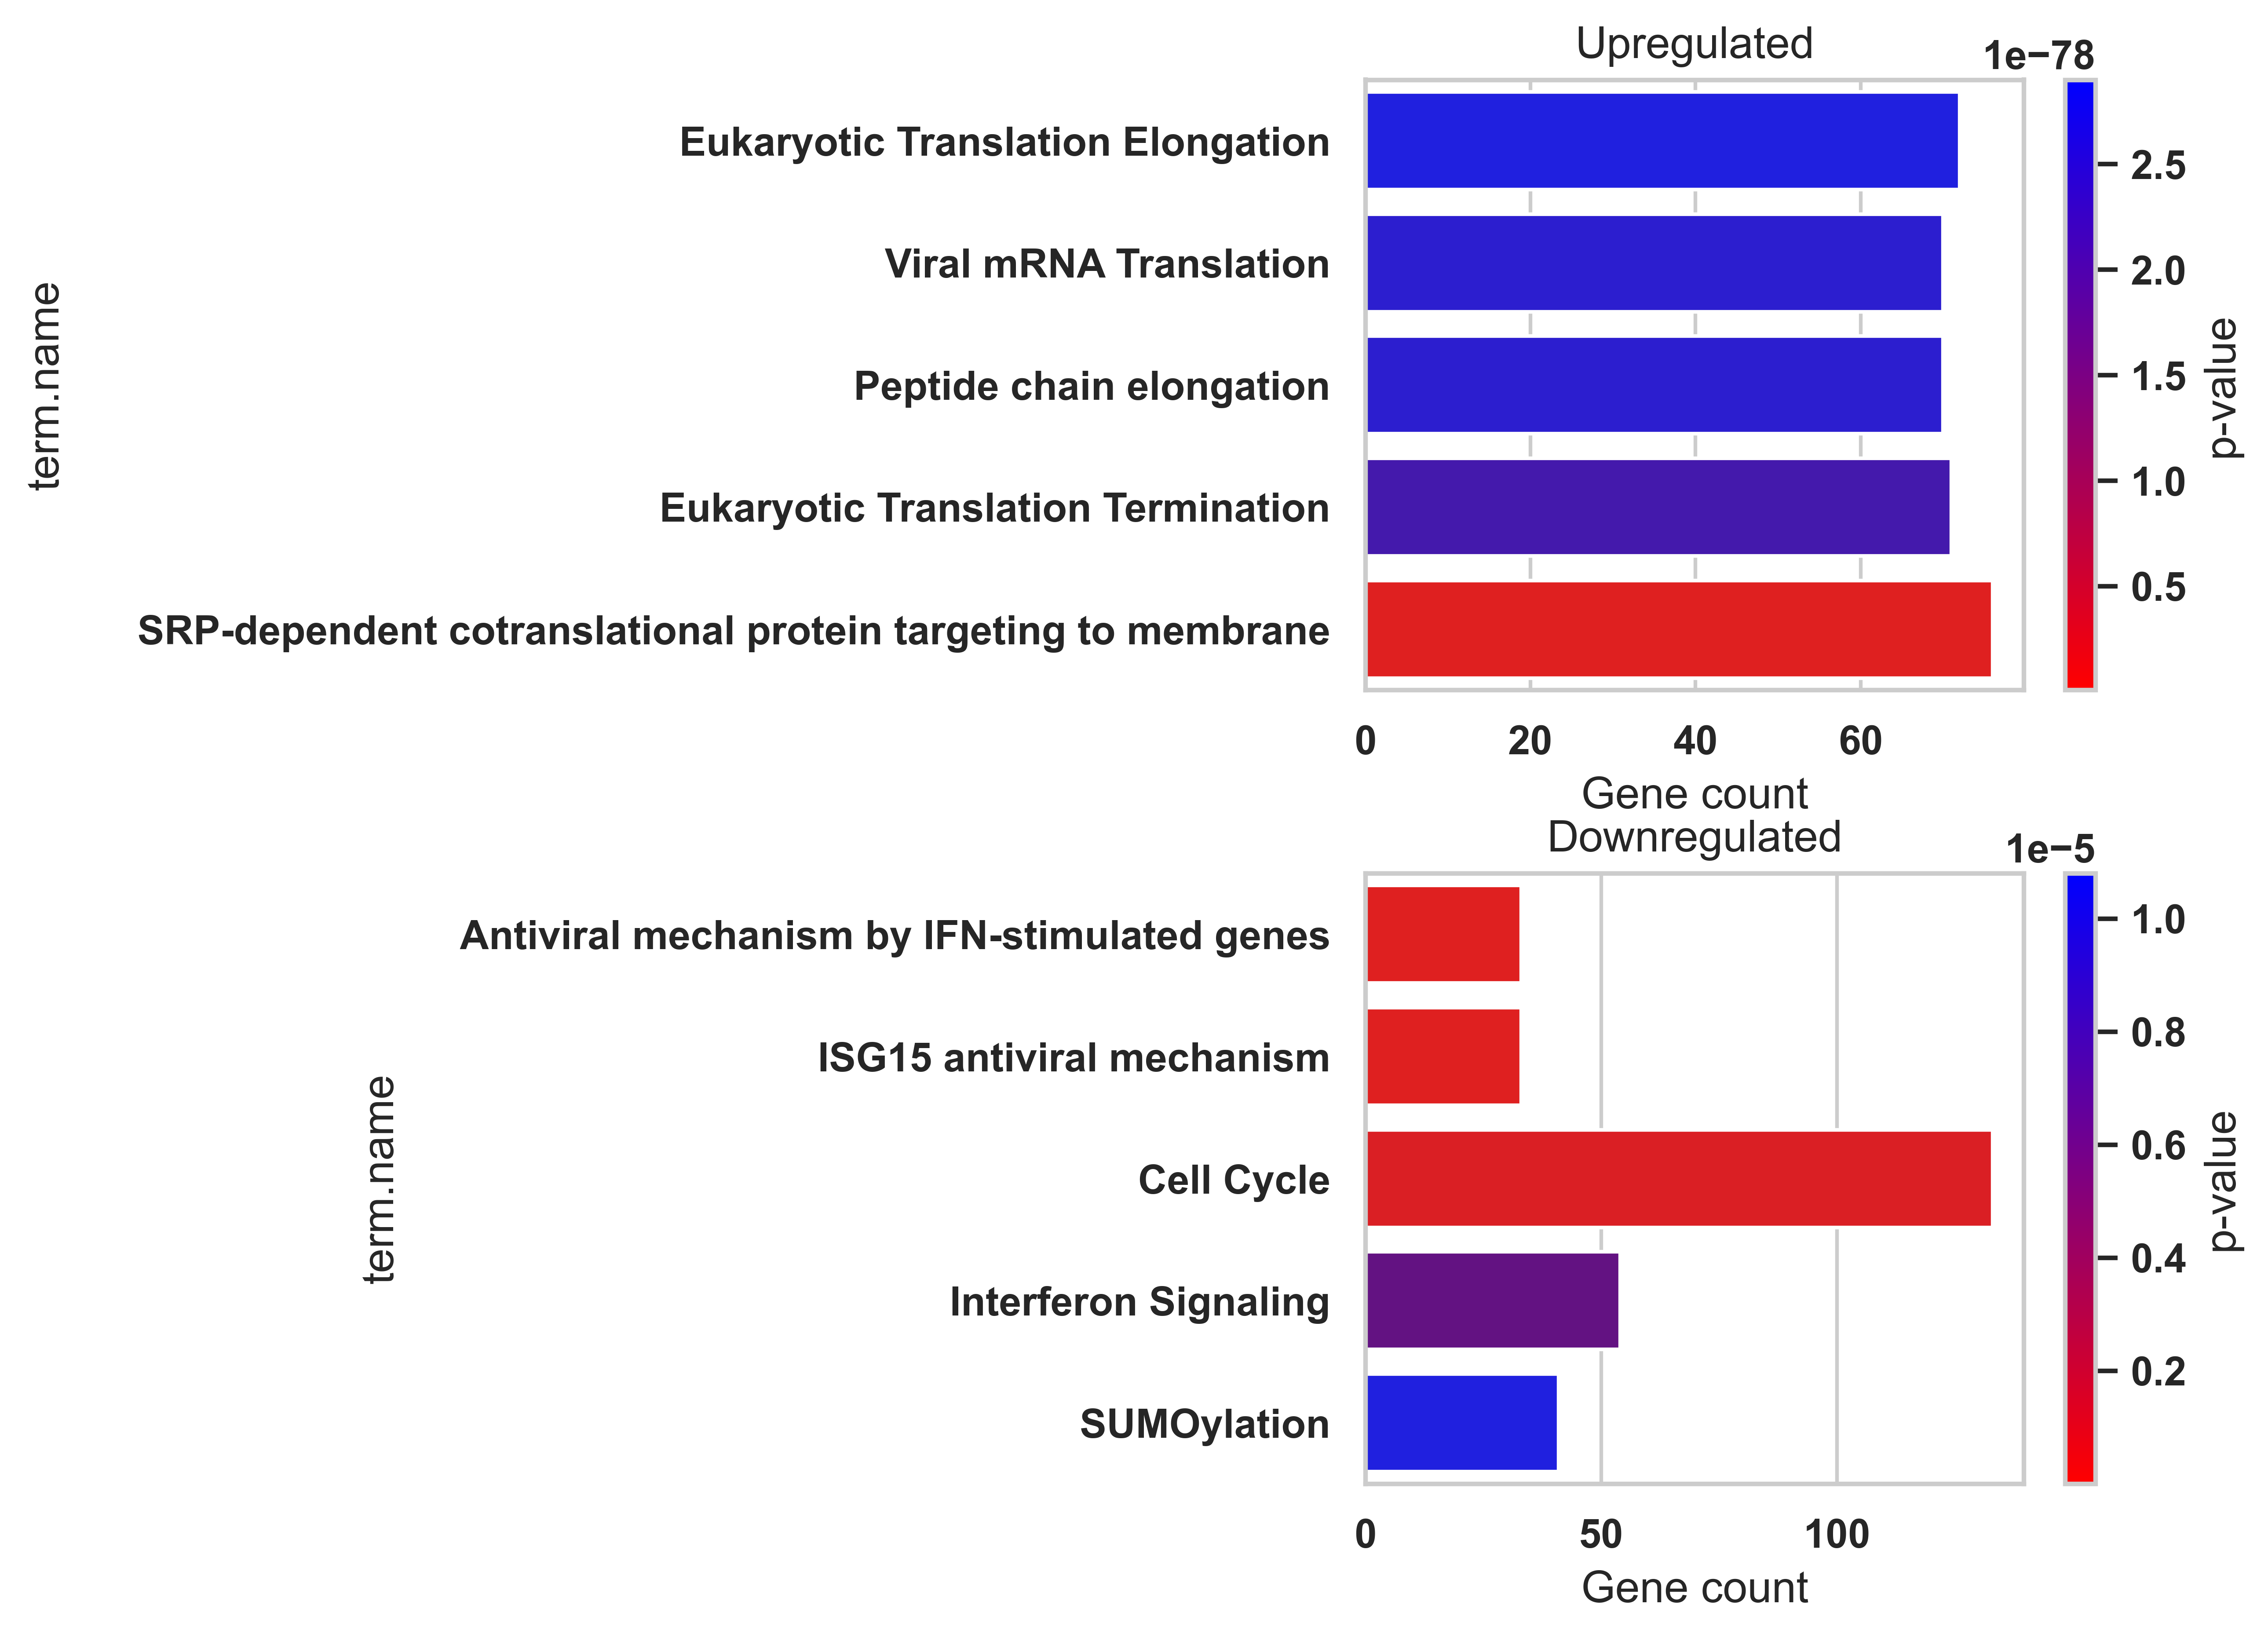

In [94]:
results = gsea(lr_params_navitoclax,
               "Navitoclax",
               "intercept",
               pval_threshold=0.01,
               value_threshold_up=0.25,
               value_threshold_down=-0.5,
               domain="rea",
               )

In [98]:
results = gsea(lr_params_navitoclax,
               "Navitoclax",
               "slope",
               pval_threshold=0.1,
               value_threshold_up=0.07,
               value_threshold_down=-0.001,
               #domain="BP",
               )

Number of genes UP: 2997, DOWN: 886
['BP' 'CC' 'MF' 'hp' 'tf']


TypeError: object of type 'NoneType' has no len()

# Trametinib (Supplementary Figure)

In [ ]:
#logfc_df_trametinib = comp_edger(adata, "Trametinib")
#logfc_df_trametinib

In [ ]:
logfc_df_trametinib = pd.read_pickle("data/logfc_df_trametinib.pkl")
logfc_df_trametinib

In [ ]:
lr_params_trametinib = comp_linear_regression(adata, "Trametinib", 1, logfc_df_navitoclax)
volcano_plot(lr_params_trametinib, "Trametinib", "intercept", pval_threshold=0.01, value_threshold=0.25)

In [ ]:
volcano_plot(lr_params_trametinib, "Trametinib", "slope", pval_threshold=0.01, value_threshold=0.25)

In [ ]:
plot_example_linear_regression(adata, "Trametinib", "RRM2", 1, logfc_df_trametinib)

In [ ]:
lr_params_trametinib = comp_linear_regression(2, logfc_df_trametinib)

In [ ]:
lr_params_trametinib.loc["EGR1"]